In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import segpath2path, pairwise_distances, point2segments
import pandas as pd
from datetime import datetime
from scipy import stats
from analysis_by_plot import myboxplot, myttests


In [2]:
import matplotlib.transforms as mtransforms

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 7.5
plt.rcParams['axes.titlesize'] = 7.5

figw2 = 3.307
figw1 = 6.85


def complete_figure(fig, axes, index):    
    trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
    for label, ax in zip(index, axes.values()):
        ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
                verticalalignment='top', fontfamily='Arial')

# straight route following

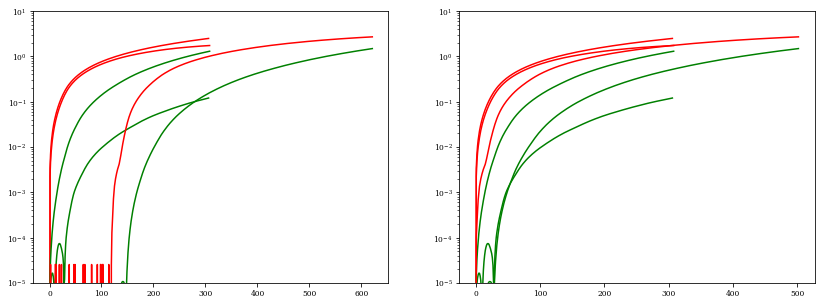

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


dir_name = 'RobotData/Route_Following/Straight/'
ls_csv_base = 'baseline.csv', 'leftwheel/csv/manual.csv', 'rightwheel/csv/manual.csv'

data_time, data_pos = {'base': [], 'left': [], 'right': []}, {'base': [], 'left': [], 'right': []}
for file_name in ls_csv_base:
    data_csv = pd.read_csv(os.path.join(dir_name, file_name))
    time, px, py = [(data_csv[key] - data_csv[key][0]).to_numpy() for key in ('timestamp', 'position_x', 'position_y')]
    
    # visualise IMU error
    axes[0].plot(np.abs(px), 'r')
    axes[0].plot(np.abs(py), 'g')
    
    time0idx = np.minimum(np.nonzero(np.abs(px) > 0.0001)[0][0], np.nonzero(np.abs(py) > 0.0001)[0][0]) - 1
    
    time = time[time0idx:] - time[time0idx]
    pos = np.array([px[time0idx:] - px[time0idx], py[time0idx:] - py[time0idx]])
        
    axes[1].plot(np.abs(pos[0]), 'r')
    axes[1].plot(np.abs(pos[1]), 'g')
    
    final_pos = pos[:, -1]
    if file_name == 'baseline.csv':
        goal_pos = final_pos
        time_mindist = len(time)
    else:
        time_mindist = np.argmin(np.linalg.norm(pos.T - goal_pos, axis=1))
    data_time['base'].append(time[:time_mindist])
    data_pos['base'].append(pos[:, :time_mindist])

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 10)

In [4]:
data_csv = pd.read_csv(os.path.join(dir_name, 'baseline.csv'))

In [5]:
42 / (data_csv['timestamp'].iloc[-1] - data_csv['timestamp'].iloc[-0])

4.13624898795473

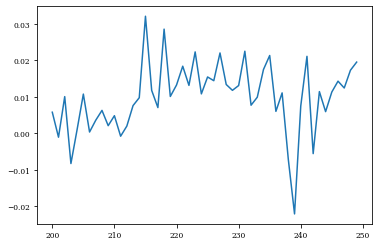

In [6]:
plt.plot(data_csv['angular_velocity_z'][200:250])

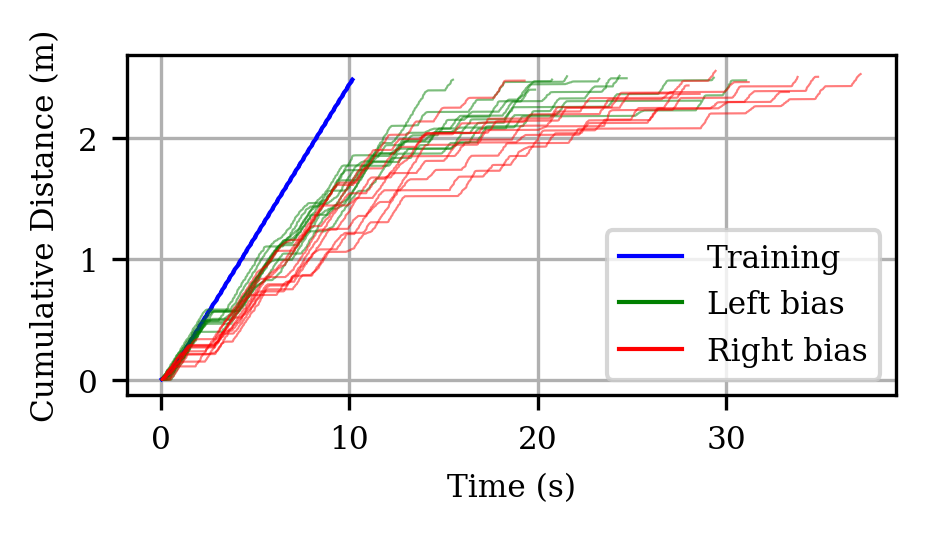

In [297]:
lw = 0.5
al = 0.3

fig, ax = plt.subplots(1, 1, figsize=(figw2, 1.5), dpi=300)

allv = []
alldxy = []
for time, pos, c in zip(data_time['base'], data_pos['base'], 'b'):
    dxy = np.linalg.norm(pos.T[1:] - pos.T[:-1], axis=1)
    dt = time[1:] - time[:-1]
    ax.plot(time[1:], np.cumsum(dxy), label='Training',
            c=c, lw=1)
    alldxy = np.concatenate((alldxy, dxy / dt))
allv.append(alldxy)

for key, lb, c in zip(['left', 'right'], ['Left bias', 'Right bias'],  'gr'):
    alldxy = []
    for time, pos in zip(data_time[key], data_pos[key]):
        dxy = np.linalg.norm(pos.T[1:] - pos.T[:-1], axis=1)
        dt = time[1:] - time[:-1]
        ax.plot(time[1:], np.cumsum(dxy), 
                c=c, lw=lw, alpha=al)
        alldxy = np.concatenate((alldxy, dxy / dt))
    allv.append(alldxy)
    
    ax.plot([], [], label=lb,
            c=c, lw=lw * 2)



ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cumulative Distance (m)')
ax.legend()

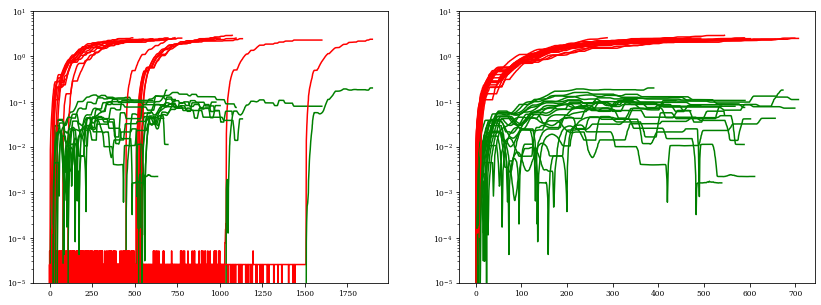

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alltime = []


data_dist_test2goal, data_dist_test2path = {'left': [], 'right': []}, {'left': [], 'right': []}
data_mindist2goal, data_dsim_test2train = {'left': [], 'right': []}, {'left': [], 'right': []}
data_mindist2basegoal, data_dsim_test2basetrain = {'left': [], 'right': []}, {'left': [], 'right': []}
n_test = 10
time_maxlen = 0
for bias, curvedbaseline in zip(('left', 'right'), data_pos['base'][1:]):
    for idx in np.arange(1, n_test + 1):
        data_csv = pd.read_csv(os.path.join(dir_name, '{}wheel/csv'.format(bias), 'test{}.csv'.format(idx)))
        time, px, py = [(data_csv[key] - data_csv[key][0]).to_numpy() for key in ('timestamp', 'position_x', 'position_y')]
        
        # visualise IMU error
        axes[0].plot(np.abs(px), 'r')
        axes[0].plot(np.abs(py), 'g')

        time0idx = np.minimum(np.nonzero(np.abs(px) > 0.0001)[0][0], np.nonzero(np.abs(py) > 0.0001)[0][0]) - 1

        time = time[time0idx:] - time[time0idx]
        pos = np.array([px[time0idx:] - px[time0idx], py[time0idx:] - py[time0idx]])
        
        alltime.append(time[-1])

        axes[1].plot(np.abs(pos[0]), 'r')
        axes[1].plot(np.abs(pos[1]), 'g')
        
        # compared to training route
        dist_test2goal = np.linalg.norm(pos.T - goal_pos, axis=1)
        time_mindist = np.argmin(dist_test2goal)
        
        time_trunc = time[:time_mindist + 1]
        pos_trunc = pos[:, :time_mindist + 1]
        dist_test2goal_trunc =  dist_test2goal[:time_mindist + 1]
        
        dsim_test2train, dist_test2path = segpath2path(pos_trunc.T, data_pos['base'][0].T)
        
        data_time[bias].append(time_trunc)
        data_pos[bias].append(pos_trunc)
        data_dist_test2goal[bias].append(dist_test2goal_trunc)
        data_dist_test2path[bias].append(dist_test2path)
        data_dsim_test2train[bias].append(dsim_test2train)
        data_mindist2goal[bias].append(dist_test2goal_trunc[-1])
        time_maxlen = np.maximum(time_maxlen, time_mindist) 
        
        # compared to baseline route
        basegoal_pos = curvedbaseline[:, -1]
        dist_test2basegoal = np.linalg.norm(pos.T - basegoal_pos, axis=1)
        time_basemindist = np.argmin(dist_test2basegoal)
        
        time_basetrunc = time[:time_basemindist + 1]
        pos_basetrunc = pos[:, :time_basemindist + 1]
        dist_test2basegoal_trunc =  dist_test2basegoal[:time_basemindist + 1]
        
        dsim_test2basetrain, dist_test2basepath = segpath2path(pos_basetrunc.T, curvedbaseline.T)

                
        data_dsim_test2basetrain[bias].append(dsim_test2basetrain)
        data_mindist2basegoal[bias].append(dist_test2basegoal_trunc[-1])
        
        
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 10)

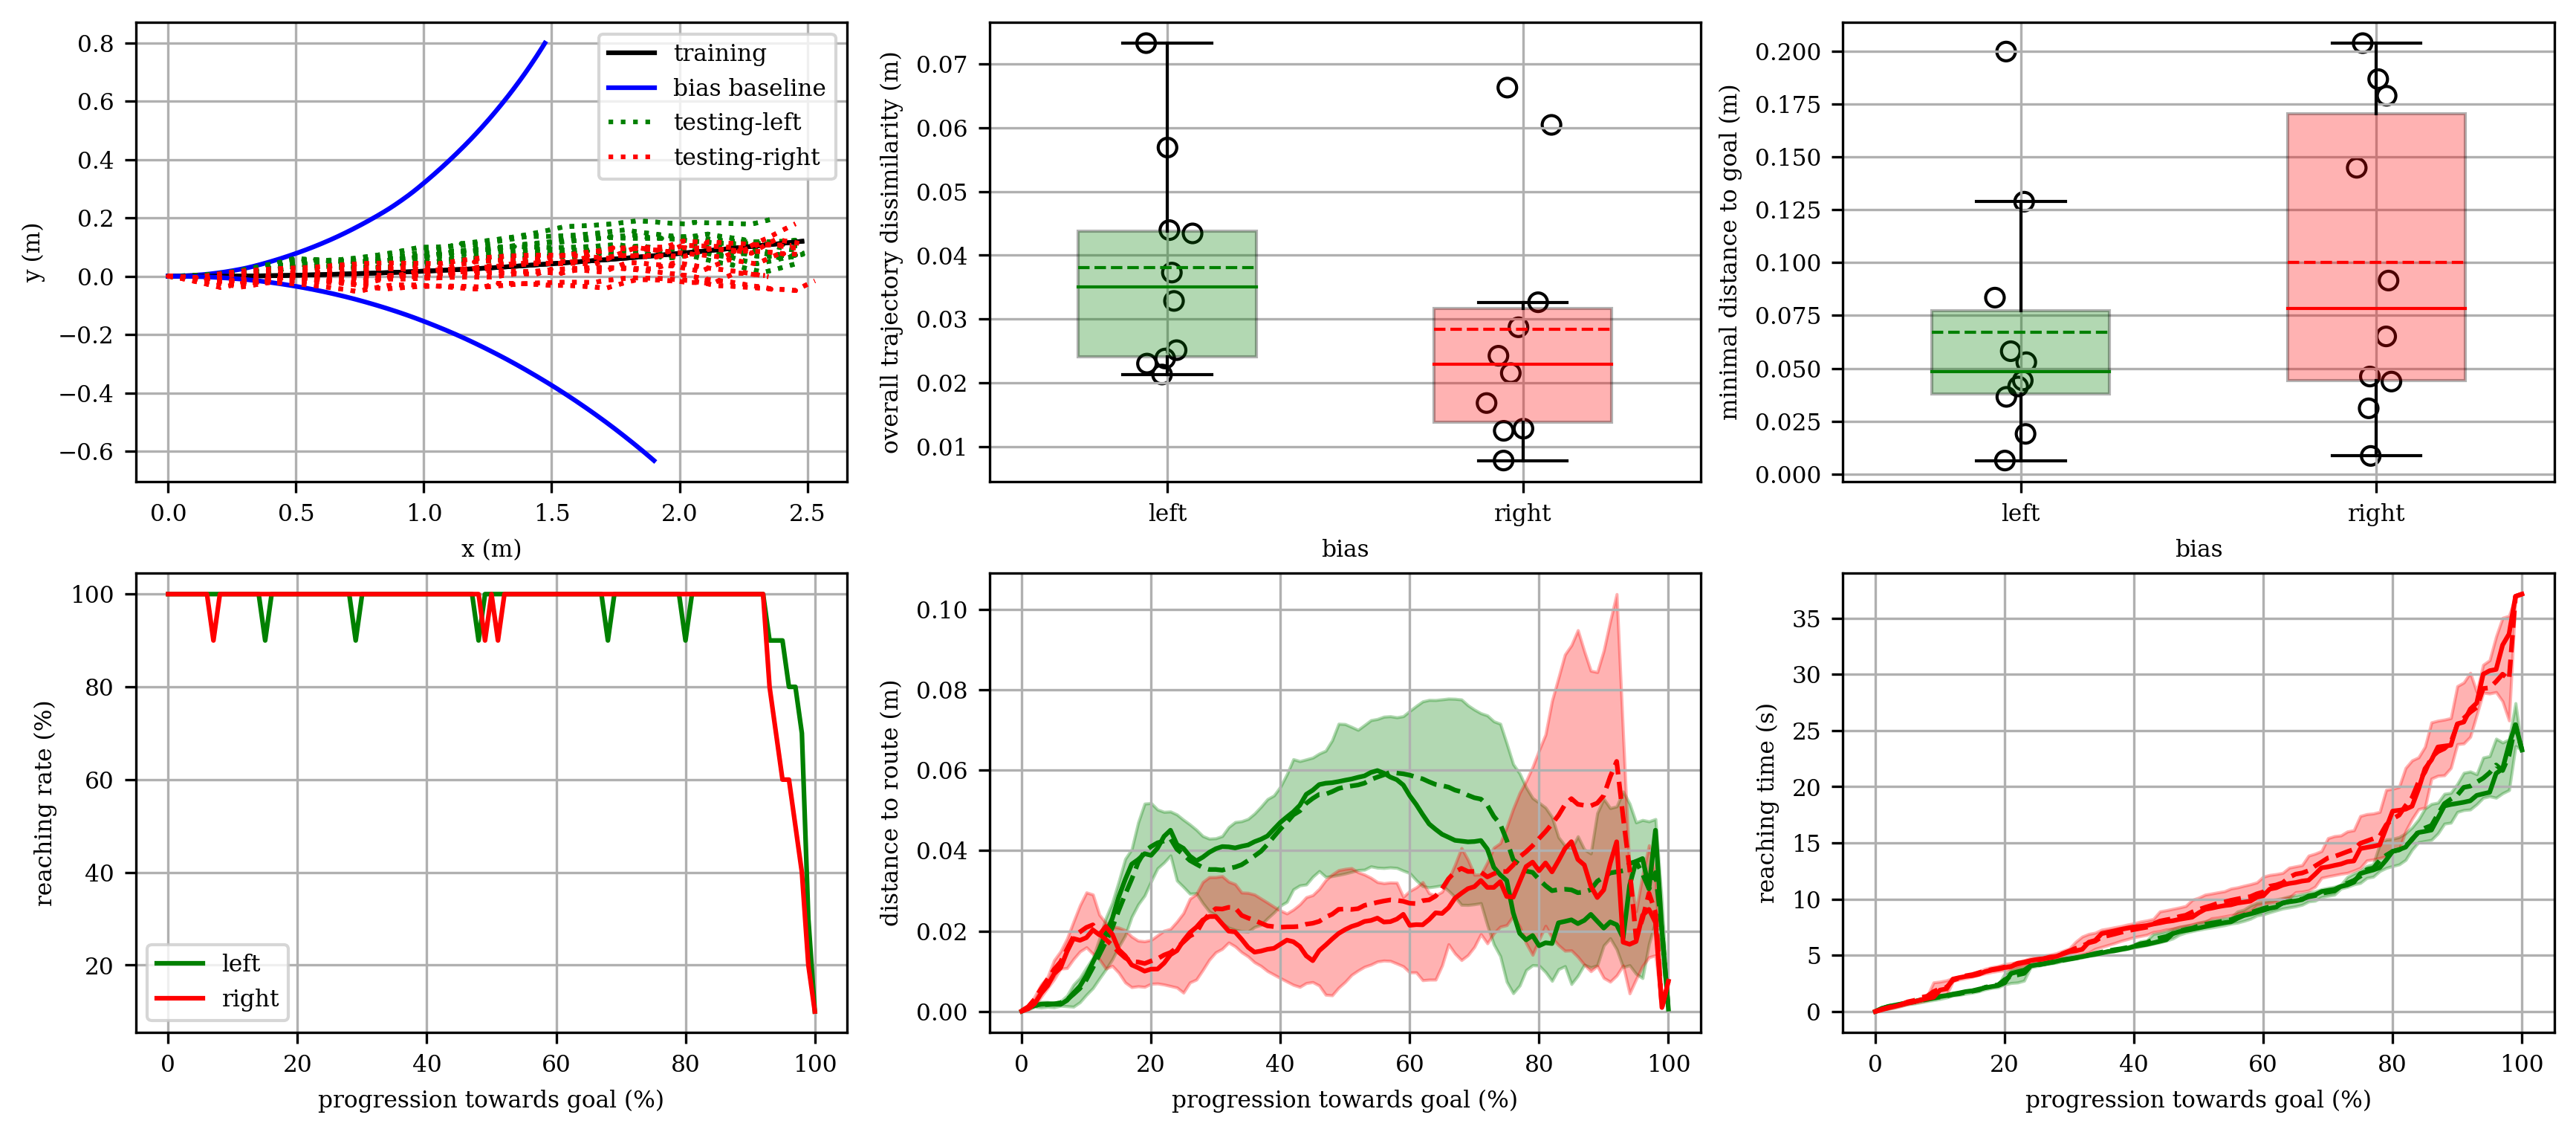

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=300)

axes[0, 0].plot([], [], color='k', label='training')
axes[0, 0].plot([], [], color='b', label='bias baseline')
for lr_base, lr, color in zip(data_pos['base'][1:], ('left', 'right'), 'gr'):
    axes[0, 0].plot(*data_pos['base'][0], color='k')
    axes[0, 0].plot(*lr_base, color='b')

    for test_pos in data_pos[lr]:
        axes[0, 0].plot(*test_pos, color=color, ls='dotted')

    axes[0, 0].plot([], [], c=color, ls='dotted', label='testing-{}'.format(lr))


ax, bx, cx = axes[1, 1], axes[1, 0], axes[1, 2]
for color, lr in zip('gr', ('left', 'right')):
    progress = np.full((n_test, time_maxlen + 1), np.nan)
    test2path = np.full((n_test, time_maxlen + 1), np.nan)
    for trial_idx, (trial_test2goal, trial_test2path) in enumerate(zip(data_dist_test2goal[lr], data_dist_test2path[lr])):
        progress[trial_idx, :len(trial_test2goal)] = np.rint((1 - np.divide(trial_test2goal, trial_test2goal[0])) * 100)
        test2path[trial_idx, :len(trial_test2goal)] = trial_test2path
    progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)
        
    
    val_test2path, val_n_point = [], []
    val_ptime = []
    true_time = np.full((n_test, len(progress_step)), np.nan)
    for trial_idx, (trial_progress, trial_test2path, trial_truetime) in enumerate(zip(progress, test2path, data_time[lr])):      
        px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
        pxinvsort = np.argsort(pxinv)
        t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort], left=np.nan, right=np.nan)
        val_test2path.append(t2p_interp)
        val_n_point.extend(px)

        ptime = np.full_like(progress_step, np.nan)
        ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
        tt = trial_truetime[ptime[~np.isnan(ptime)].astype(int)]
        val_ptime.append(ptime)
        true_time[trial_idx, :len(tt)] = tt


    ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
    ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)

    ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)

    p_reach, n_reach = np.unique(val_n_point, return_counts=True)
    bx.plot(p_reach, n_reach * 10, color=color, label=lr)

    cx.plot(progress_step, np.nanmean(true_time, axis=0), color=color, ls='dashed')
    cx.plot(progress_step, np.nanmedian(true_time, axis=0), color=color)
    cx.fill_between(progress_step, *np.nanquantile(true_time, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        

        
for ax, ddd in zip(axes[0, 1:], (data_dsim_test2train, data_mindist2goal)):
    for xx, cond in enumerate(('left', 'right')):
        yy = ddd[cond]
        ax.scatter(np.random.normal(xx + 1, 0.04, len(yy)), yy, facecolor='none', edgecolor='k')
        
    bp = ax.boxplot([ddd[bias] for bias in ('left', 'right')], showfliers=False, showmeans=True, meanline=True,
                    patch_artist=True, labels=('left', 'right'), widths=0.5)

    for patch, color in zip(bp['boxes'], 'gr'):
        patch.set_facecolor(color)
        patch.set_alpha(0.3)
    for linekey in ('means', 'medians'):
        for line, color in zip(bp[linekey], 'gr'):
            line.set_color(color)
        
        
        
for ax, yl in zip(axes[1], ('reaching rate (%)', 'distance to route (m)', 'reaching time (s)')):
#     ax.set_xlim(0, 100)
    ax.grid()
    ax.set_ylabel(yl)
    ax.set_xlabel('progression towards goal (%)')

for ax in axes.T[0]:
    ax.legend(loc=0)

for ax, xl, yl in zip(axes[0], ('x (m)', 'bias', 'bias'), 
                      ('y (m)', 'overall trajectory dissimilarity (m)', 'minimal distance to goal (m)')):
    ax.grid()
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)

In [110]:
np.mean(alltime)

28.286267113685607

In [111]:
data_dsim_test2basetrain

{'left': [0.1648781231438344,
  0.14224286637712003,
  0.1527877241732251,
  0.1511422289006693,
  0.13778070462667857,
  0.18544783698920073,
  0.14771510042083433,
  0.16032693659174535,
  0.16846162418006771,
  0.16688233089140656],
 'right': [0.2060064390981071,
  0.16526237448191533,
  0.20385063077297894,
  0.16074957368327447,
  0.1794387569240409,
  0.19203329156875715,
  0.15754857246149917,
  0.19389345812766515,
  0.22422677714913894,
  0.208691132926085]}

(4, 10)
(4, 10)


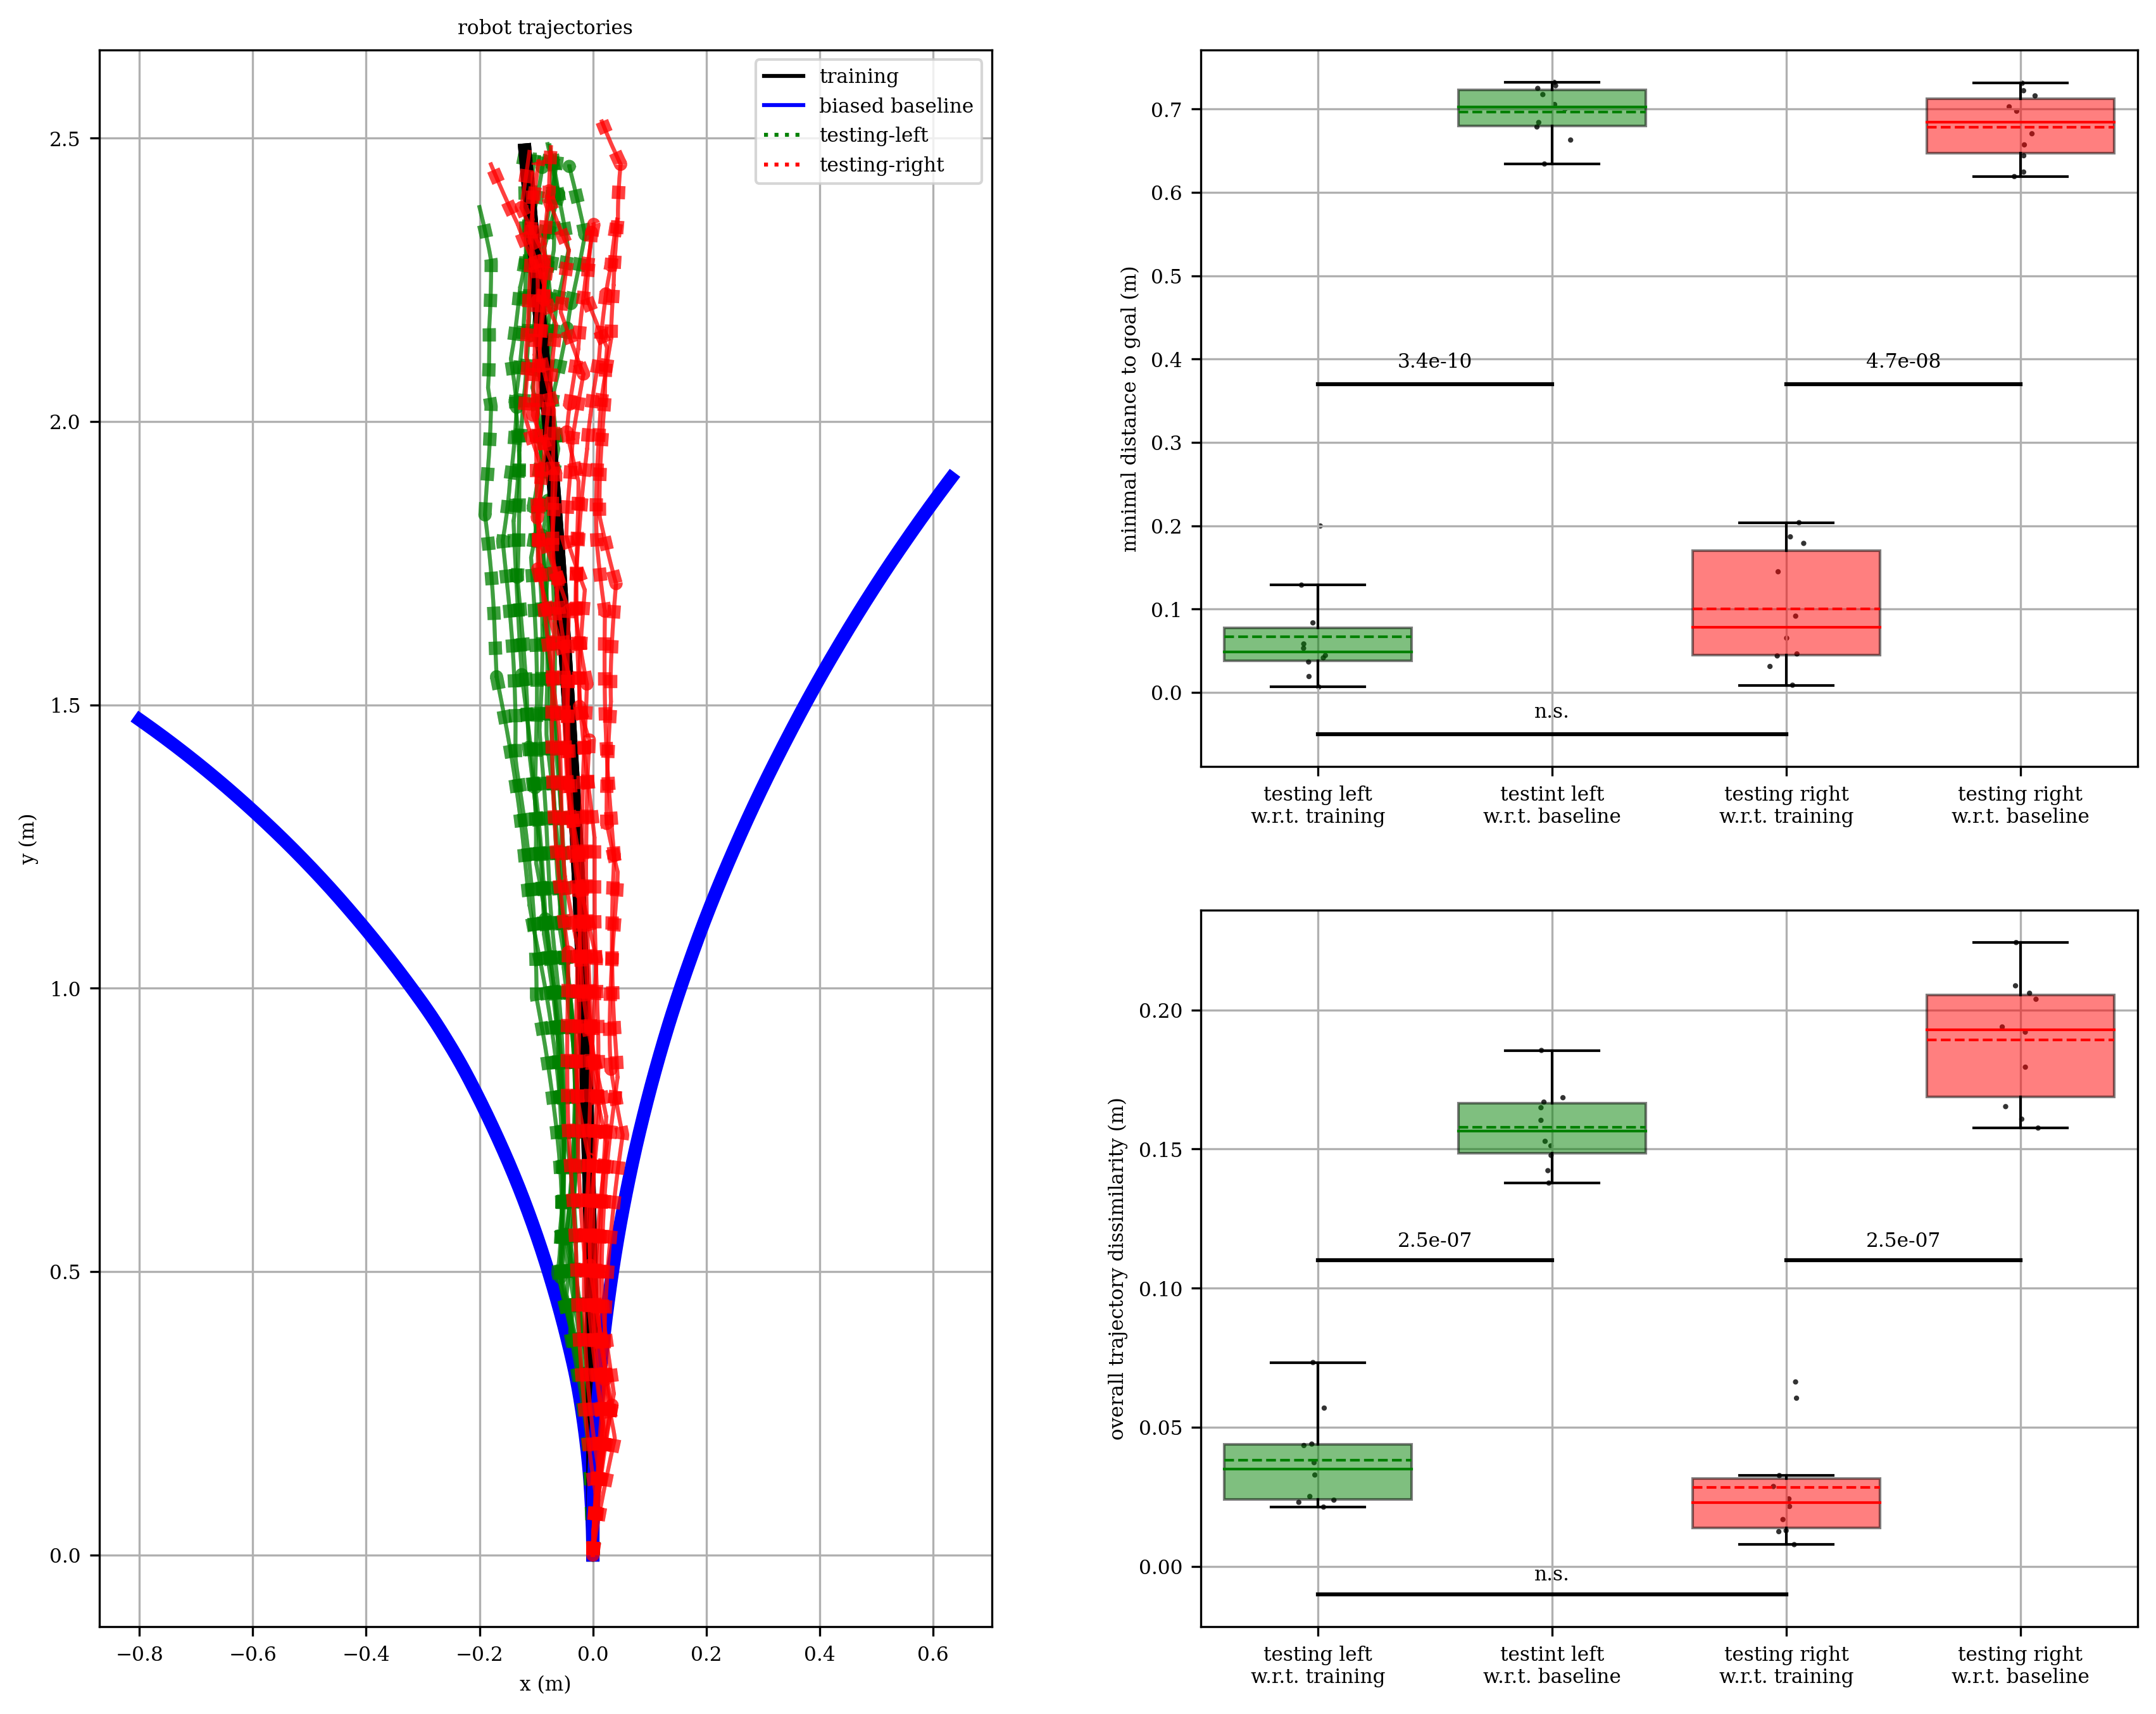

In [112]:
lw = 5

fig, axes = plt.subplot_mosaic('''
                                AB
                                AC
                                ''', figsize=(14, 11), dpi=300)

ax = axes['A']
ax.plot([], [], color='k', label='training')
ax.plot([], [], color='b', label='biased baseline')
for lr_base, lr, color in zip(data_pos['base'][1:], ('left', 'right'), 'gr'):
    ax.plot(-data_pos['base'][0][1], data_pos['base'][0][0], color='k', lw=lw)
    ax.plot(-lr_base[1], lr_base[0], color='b', lw=lw)

    for test_pos in data_pos[lr]:
        ax.plot(-test_pos[1], test_pos[0], color=color, alpha=0.5, ls='dotted', lw=lw)
        ax.plot(-test_pos[1], test_pos[0], color=color, alpha=0.5)

    ax.plot([], [], c=color, ls='dotted', label='testing-{}'.format(lr))

ax.set_aspect('equal')
ax.set_title('robot trajectories')
ax.legend(loc=0)


comparison_index = np.array([[0, 1], [2, 3], [0, 2]])
data_pval = []
for ak, data_train, data_base in zip('BC', (data_mindist2goal, data_dsim_test2train), (data_mindist2basegoal, data_dsim_test2basetrain)):
    ax = axes[ak]
    data = []
    for lr in ('left', 'right'):
        for alldata in (data_train[lr], data_base[lr]):
            data.append(alldata)
    myboxplot(ax, data, 
              ('testing left\nw.r.t. training', 'testint left\nw.r.t. baseline', 'testing right\nw.r.t. training', 'testing right\nw.r.t. baseline'), 'ggrr', 0.8, 1)
    pvalues = myttests(data, comparison_index[:2], ispaired=True)
    print(np.shape(data))
    pvalues.extend(myttests(data, [comparison_index[2]], ispaired=False, permutations=100000))
    data_pval.append(pvalues)


    for patch, color in zip(bp['boxes'], 'gr'):
        patch.set_facecolor(color)
        patch.set_alpha(0.3)
    for linekey in ('means', 'medians'):
        for line, color in zip(bp[linekey], 'gr'):
            line.set_color(color)
        
        
for ak, pvalues, h, ys in zip('BC', data_pval, (0.02, 0.005), ((0.37, 0.37, -0.05), (0.11, 0.11, -0.01))):
    ax = axes[ak]
    for pval, y, (xa, xb) in zip(pvalues, ys, comparison_index + 1):
        ax.plot([xa, xb], [y, y], color='k')
        if pval == 0:
            plabel = 'e.s.'
        elif pval <= 0.05:
            plabel = '{:.1e}'.format(pval)
        else:
            plabel = 'n.s.'
        ax.text((xa + xb) / 2, y + h, plabel, horizontalalignment='center')
        
        

for ak, xl, yl in zip('ABC', ('x (m)', '', ''), 
                      ('y (m)', 'minimal distance to goal (m)', 'overall trajectory dissimilarity (m)')):
    ax = axes[ak]
    ax.grid()
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)

In [113]:
data_train.values()

dict_values([[0.043951663312442074, 0.03729255447838663, 0.07326974265936213, 0.04343402473660193, 0.05689760115497154, 0.02302249508981554, 0.0328456314945357, 0.02381639297935215, 0.021310212449545462, 0.025127844227335976], [0.01683567362513312, 0.0662950941119226, 0.007821467260183653, 0.060451407774201965, 0.02871603543815983, 0.012481821300073042, 0.01281590676918563, 0.03264055888346762, 0.024252562236172455, 0.021532417123197086]])

In [114]:
from analysis_by_plot import *

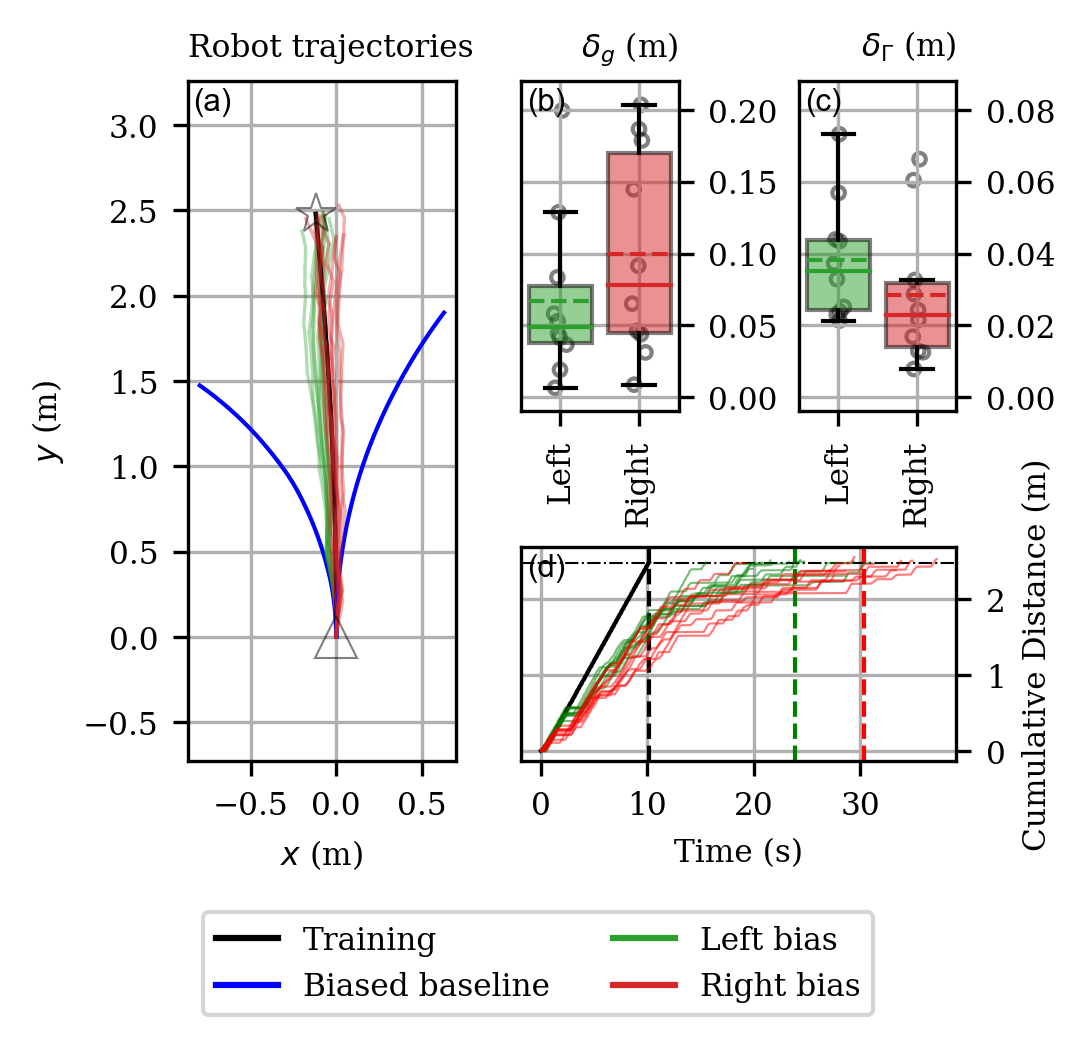

In [331]:
lw = 1

fig, axes = plt.subplot_mosaic('''
                                AAAAA.BBB..CCC
                                AAAAA.BBB..CCC
                                AAAAA.BBB..CCC
                                AAAAA.........
                                AAAAA.DDDDDDDD
                                AAAAA.DDDDDDDD
                                ''', figsize=(figw2, 3), dpi=300)

ax = axes['A']
ax.plot([], [], color='k', label='Training')
ax.plot([], [], color='b', label='Biased baseline')

    
###################

lw = 0.5
al = 0.3

ax = axes['D']

allv = []
alldxy = []
for time, pos, c in zip(data_time['base'], data_pos['base'], 'k'):
    dxy = np.linalg.norm(pos.T[1:] - pos.T[:-1], axis=1)
    dt = time[1:] - time[:-1]
    cumdist = np.cumsum(dxy)
    ax.plot(time[1:], cumdist, label='Training',
            c=c, lw=1)
    alldxy = np.concatenate((alldxy, dxy / dt))
allv.append(alldxy)
ax.axvline(time[-1], color=c, ls='dashed', lw=1)
ax.axhline(cumdist[-1], color=c, ls='-.', lw=0.5)


for key, lb, c in zip(['left', 'right'], ['Left bias', 'Right bias'],  'gr'):
    alldxy = []
    total_time = []
    for time, pos in zip(data_time[key], data_pos[key]):
        dxy = np.linalg.norm(pos.T[1:] - pos.T[:-1], axis=1)
        dt = time[1:] - time[:-1]
        ax.plot(time[1:], np.cumsum(dxy), 
                c=c, lw=lw, alpha=al)
        alldxy = np.concatenate((alldxy, dxy / dt))
        total_time.append(time[-1])
        
    allv.append(alldxy)
    ax.axvline(np.mean(total_time), color=c, ls='dashed', lw=1)
    
    ax.plot([], [], label=lb,
            c=c, lw=lw * 2)



# ax.grid()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cumulative Distance (m)')
ax.set_xticks([0, 10, 20, 30])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


########################
lw = 1

ax = axes['A']

for lr_base, lr, lb, color in zip(data_pos['base'][1:], ('left', 'right'), ('Left', 'Right'), ('tab:green', 'tab:red')):
    ax.plot(-data_pos['base'][0][1], data_pos['base'][0][0], color='k', lw=lw)
    
    ax.plot(-lr_base[1], lr_base[0], color='b', lw=lw)

    for test_pos in data_pos[lr]:
        ax.plot(-test_pos[1], test_pos[0], color=color, alpha=0.2, lw=0.8)

    ax.plot([], [], c=color, label='{} bias'.format(lb))
    
ax.plot(data_pos['base'][0][0][0], data_pos['base'][0][1][0], c='k', alpha=0.5, 
            marker='^', markersize=10, mfc='none', markeredgewidth=lw/2)
ax.plot(-data_pos['base'][0][1][-1], data_pos['base'][0][0][-1], c='k', alpha=0.5, 
            marker='*', markersize=10, mfc='none', markeredgewidth=lw/2)

ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Robot trajectories', fontsize=7.5, loc='left')
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=2)

ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')

ls_lr = 'left', 'right'
for ak, dataname, tit in zip('BC', 
                    (data_mindist2goal, data_dsim_test2train),
                    ('$\delta_g$ (m)', '$\delta_\Gamma$ (m)')):
    ax = axes[ak]
    myboxplot(ax, [dataname[_] for _ in ls_lr], ls_lr, ('tab:green', 'tab:red'), 0.5, 9)
    ax.set_xticklabels(('Left', 'Right'), rotation=90)
    ax.set_title(tit, fontsize=7.5, loc='right')
    ax.yaxis.tick_right()

for ax in axes.values():
    ax.grid()
    
    
axes['B'].set_yticks(np.linspace(0, 0.2, 5))
axes['B'].set_ylim(-0.01, 0.22)
axes['C'].set_yticks(np.linspace(0, 0.08, 5))
axes['C'].set_ylim(-0.004, 0.088)

complete_figure(fig, axes, 'abcd')

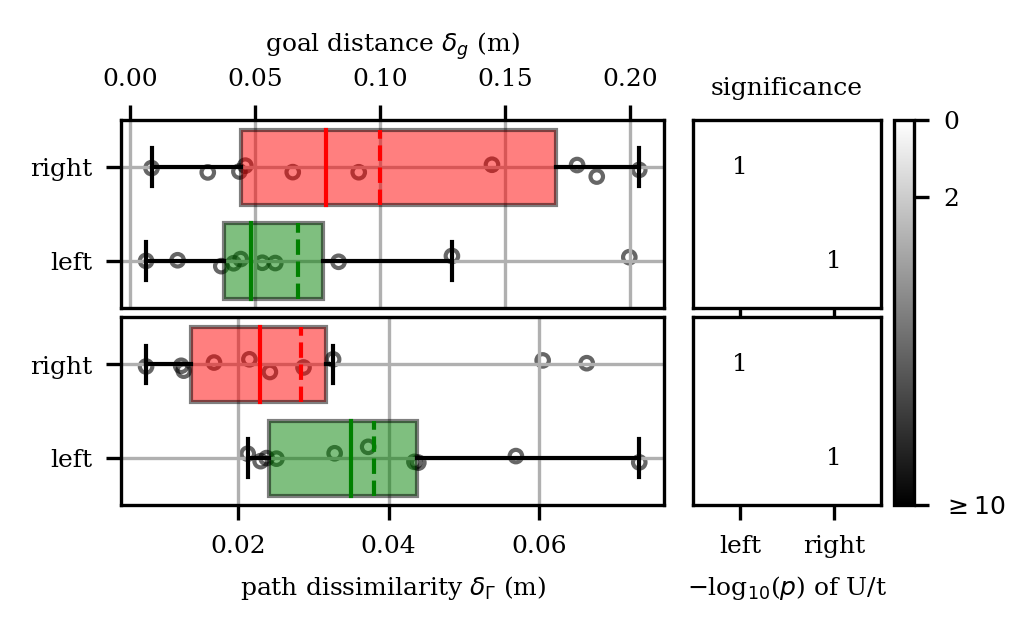

In [16]:
ls_lr = 'left', 'right'

data_goaldist = [data_mindist2goal[model_name] for model_name in ls_lr]
data_pathdsim = [data_dsim_test2train[model_name] for model_name in ls_lr]

plot2metric(data_goaldist, data_pathdsim, ls_lr, ls_lr, 'gr', 
            dot_alpha=0.6, dot_size=9, figsize=(3.5, 1.7))

# curved route following

2023-08-24 13:21:06.163965
4.376163825098569
2023-08-23 12:42:48.022179
5.341731480394171


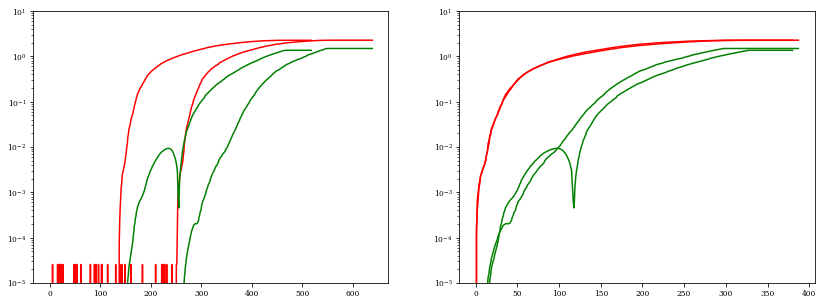

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


ls_lr = 'left', 'right'
n_image = 116, 117
# n_image = 461, 922
data_train, goal_pos = {}, {}
for lr in ls_lr:
    data_train[lr] = {'time': [], 'pos': []}

dir_name = 'RobotData/Route_Following/Curved_tidy/'
for lr, n_i in zip(ls_lr, n_image):
    file_train = os.path.join(dir_name, lr, 'baseline.csv')
    csv_raw = pd.read_csv(file_train)
    print(datetime.fromtimestamp(csv_raw['timestamp'][0]))
    
    time, px, py = [(csv_raw[key] - csv_raw[key][0]).to_numpy() for key in ('timestamp', 'position_x', 'position_y')]
    
    print(n_i / time[-1])
    
    # visualise IMU error
    axes[0].plot(np.abs(px), 'r')
    axes[0].plot(np.abs(py), 'g')
    
    time0idx = np.minimum(np.nonzero(np.abs(px) > 0.0001)[0][0], np.nonzero(np.abs(py) > 0.0001)[0][0]) - 1
    
    time = time[time0idx:] - time[time0idx]
    pos = np.array([px[time0idx:] - px[time0idx], py[time0idx:] - py[time0idx]])
    
    axes[1].plot(np.abs(pos[0]), 'r')
    axes[1].plot(np.abs(pos[1]), 'g')
    
    goal_pos[lr] = pos[:, -1]    
    time_mindist = len(time)
    data_train[lr]['time'].append(time[:time_mindist])
    data_train[lr]['pos'].append(pos[:, :time_mindist])

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 10)

2023-08-24 15:10:15.033038
2023-08-24 15:45:48.137207
2023-08-24 14:57:11.262282
2023-08-24 15:43:03.749702
2023-08-24 15:13:25.857934
2023-08-24 15:48:34.182997
2023-08-24 15:20:23.699523
2023-08-24 15:17:08.006295
2023-08-24 15:40:19.054257
2023-08-24 14:37:24.062673
2023-08-24 14:29:56.964515
2023-08-24 14:44:47.057588
2023-08-24 14:52:59.263849
2023-08-24 15:37:22.007720
2023-08-24 14:40:52.549713


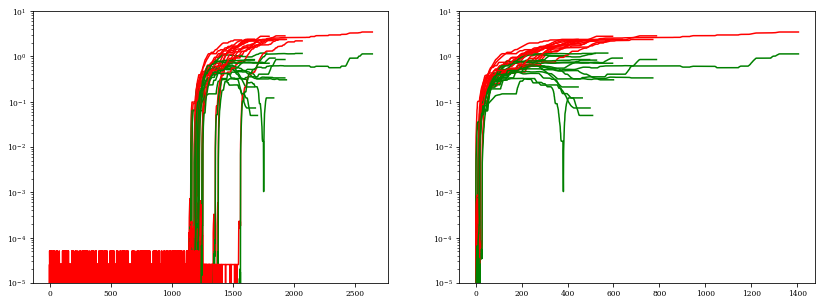

In [124]:
data_test = {'d2_left': {'time': [], 'pos': [], 'pos_all': []}}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



dir_left = os.path.join(dir_name, 'left/original_csv')
for file_name in os.listdir(dir_left):
    csv_raw = pd.read_csv(os.path.join(dir_left, file_name))
    print(datetime.fromtimestamp(csv_raw['timestamp'][0]))
    
    time, px, py = [(csv_raw[key] - csv_raw[key][0]).to_numpy() for key in ('timestamp', 'position_x', 'position_y')]
    
    # visualise IMU error
    axes[0].plot(np.abs(px), 'r')
    axes[0].plot(np.abs(py), 'g')
    
    time0idx = np.minimum(np.nonzero(np.abs(px) > 0.0001)[0][0], np.nonzero(np.abs(py) > 0.0001)[0][0]) - 1
    
    time = time[time0idx:] - time[time0idx]
    pos = np.array([px[time0idx:] - px[time0idx], py[time0idx:] - py[time0idx]])
    
    axes[1].plot(np.abs(pos[0]), 'r')
    axes[1].plot(np.abs(pos[1]), 'g')
    
    time_mindist = np.argmin(np.linalg.norm(pos.T - goal_pos['left'], axis=1))
    data_test['d2_left']['time'].append(time[:time_mindist])
    data_test['d2_left']['pos'].append(pos[:, :time_mindist])

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 10)

In [125]:
print(data_train['left']['time'][0][-1])
print(data_train['right']['time'][0][-1])

17.89940619468689
16.99801278114319


d1_bothoff
2023-08-23 17:30:15.345882
2023-08-23 17:34:37.451217
2023-08-23 17:25:20.568337
2023-08-23 17:16:50.108441
2023-08-23 17:38:37.198499
d1_control
2023-08-23 13:53:57.011913
2023-08-23 13:50:17.197317
2023-08-23 13:47:29.941103
2023-08-23 14:25:13.150093
2023-08-23 14:05:16.568459
2023-08-23 14:29:35.075581
2023-08-23 14:10:46.088392
2023-08-23 14:15:56.567313
2023-08-23 14:01:06.740425
2023-08-23 13:17:42.611073
2023-08-23 13:12:03.598388
2023-08-23 13:26:46.379102
2023-08-23 13:42:02.085306
2023-08-23 13:31:10.245351
2023-08-23 13:23:00.993889
d1_leftoff
2023-08-23 16:19:40.158878
2023-08-23 16:01:56.955866
2023-08-23 15:53:27.562000
2023-08-23 16:25:18.549298
2023-08-23 14:42:32.182504
2023-08-23 14:44:47.422165
2023-08-23 14:38:54.087238
2023-08-23 15:50:47.999417
2023-08-23 15:57:34.227257
2023-08-23 14:44:47.422165
d1_rightoff
2023-08-23 16:49:59.478881
2023-08-23 16:45:51.042817
2023-08-23 16:52:53.261424
2023-08-23 16:58:58.206722
2023-08-23 16:55:46.726583
2023-08-23

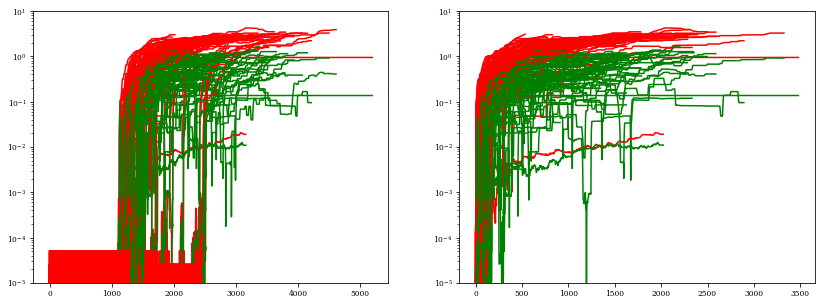

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ls_right_condition = 'd1_control', 'd2_control', 'd3_control', 'd1_leftoff', 'd1_rightoff', 'd1_bothoff', 'd3_nowheel'
dir_right = os.path.join(dir_name, 'right')
for rc, color in zip(np.sort(ls_right_condition), colors):
    data_test[rc] = {'time': [], 'pos': [], 'pos_all': []}

    print(rc)
    subdir = os.path.join(dir_right, rc)
    for file_name in os.listdir(subdir):
        csv_raw = pd.read_csv(os.path.join(subdir, file_name))
        print(datetime.fromtimestamp(csv_raw['timestamp'][0]))
        
        time, px, py = [(csv_raw[key] - csv_raw[key][0]).to_numpy() for key in ('timestamp', 'position_x', 'position_y')]
        
        # visualise IMU error
        axes[0].plot(np.abs(px), 'r')
        axes[0].plot(np.abs(py), 'g')

        time0idx = np.minimum(np.nonzero(np.abs(px) > 0.0001)[0][0], np.nonzero(np.abs(py) > 0.0001)[0][0]) - 1

        time = time[time0idx:] - time[time0idx]
        pos = np.array([px[time0idx:] - px[time0idx], py[time0idx:] - py[time0idx]])

        axes[1].plot(np.abs(pos[0]), 'r')
        axes[1].plot(np.abs(pos[1]), 'g')

        time_mindist = np.argmin(np.linalg.norm(pos.T - goal_pos['right'], axis=1))

        data_test[rc]['time'].append(time[:time_mindist])
        data_test[rc]['pos'].append(pos[:, :time_mindist])
        data_test[rc]['pos_all'].append(pos)

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 10)

In [127]:
data_train.keys(), data_test.keys()

(dict_keys(['left', 'right']),
 dict_keys(['d2_left', 'd1_bothoff', 'd1_control', 'd1_leftoff', 'd1_rightoff', 'd2_control', 'd3_control', 'd3_nowheel']))

In [128]:
alltime_l, alltime_r = [], []
for key, val in data_test.items():
    if key == 'd2_left':
        [alltime_l.append(time[-1]) for time in val['time']]
    else:
        [alltime_r.append(time[-1]) for time in val['time']]
print(np.mean(alltime_l), np.mean(alltime_r))

24.23679084777832 68.53250669311075


fig, ax = plt.subplot_mosaic('''
                            HIJ
                            EFG
                            CBB
                            ABB
                            ''', figsize=(14, 20), sharex=True, sharey=True, dpi=300)
lw = 3
alpha = 0.5

# training
### add left bias baseline
for lr, color in zip(ls_lr, 'gr'):
    ax['B'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c=color, label=lr, lw=lw)
ax['B'].plot(data_train['left']['pos'][0][1], data_train['left']['pos'][0][0], 
             c='g', ls='dashed', label='left-mirrored', lw=lw)

ax['B'].legend()
ax['B'].set_title('training routes')

# control
for ak, cond, tt in zip('HIJ', ('d1_control', 'd2_control', 'd3_control'), ('day 1', 'day 2', 'day 3')):
    ctrl = ' (control)' if ak == 'H' else ' '
    ax[ak].set_title('{}\n\nright route baseline{} $N={}$'.format(tt, ctrl, len(data_test[cond]['pos'])))
    for x, y in data_test[cond]['pos']:
        ax[ak].plot(-y, x, color='r', alpha=alpha, lw=lw)
        
        
# lighting
for ak, cond, tt in zip('ECA', ('d1_leftoff', 'd1_rightoff', 'd1_bothoff'), ('right lights', 'left lights', 'no lights')):
    ax[ak].set_title('{} $N={}$'.format(tt, len(data_test[cond]['pos'])))
    for x, y in data_test[cond]['pos']:
        ax[ak].plot(-y, x, color='r', alpha=alpha, lw=lw)
        
        
# left
ax['F'].axhline(0, ls='dashed', color='k')
for x, y in data_test['d2_left']['pos']:
    ax['F'].plot(-y, x, color='g', alpha=alpha)
    ax['F'].plot(y, x, color='g', ls='dashed', alpha=alpha, lw=lw)
    
ax['F'].set_title('left route baseline $N={}$'.format(len(data_test['d2_left']['pos'])))
        
    
# wheel
for x, y in data_test['d3_nowheel']['pos']:
    ax['G'].plot(-y, x, color='r', alpha=alpha, lw=lw)
    
ax['G'].set_title('left tyre removed $N={}$'.format(len(data_test['d3_nowheel']['pos'])))

ax['B'].tick_params(reset=True, grid_linestyle='solid')
for a in ax.values():
    a.set_aspect('equal')
    a.set_xlabel('x (m)')
    a.set_ylabel('y (m)')
    a.grid()

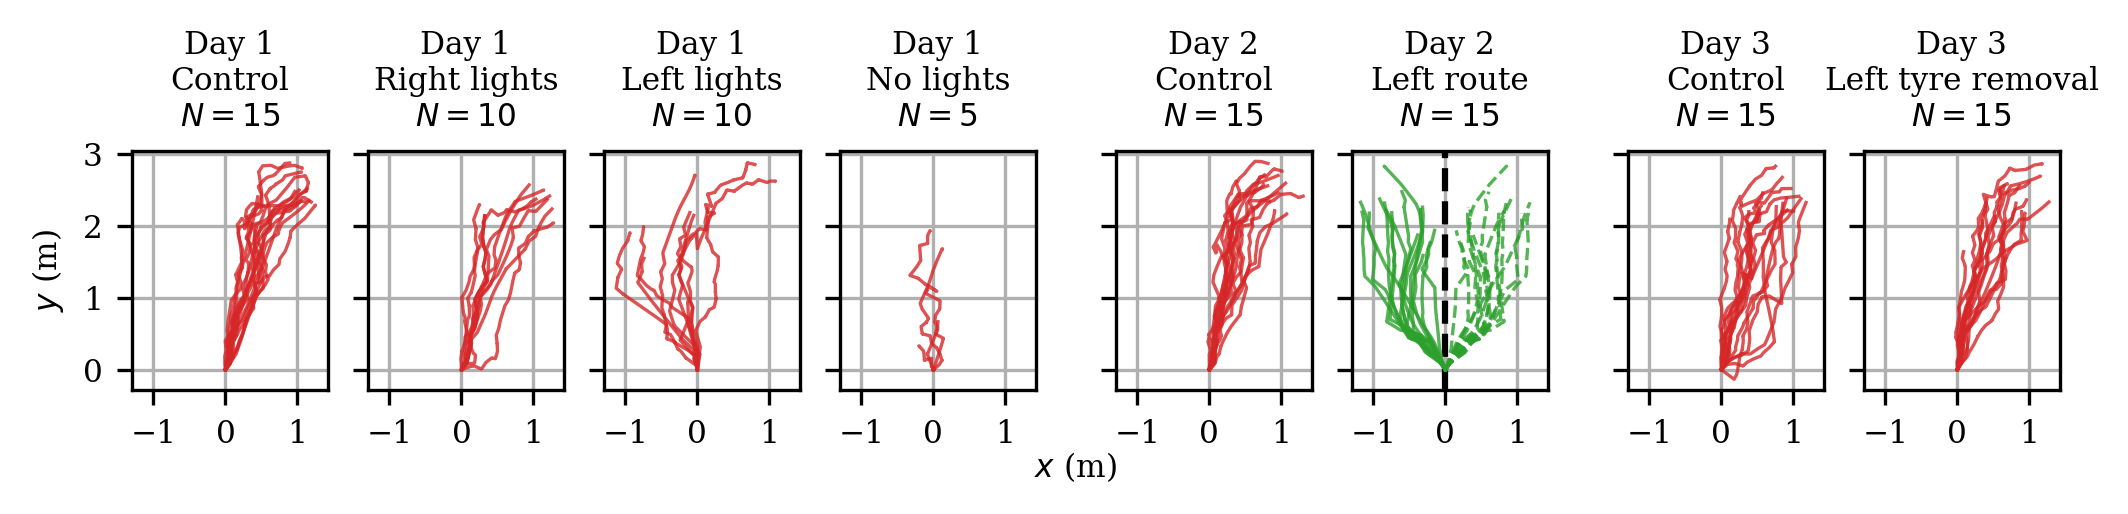

In [48]:
fig, ax = plt.subplot_mosaic('''
                            HECAIFJG
                            ''', figsize=(figw1, 3), sharex=True, sharey=True, dpi=300, layout='constrained')
lw = 0.8
alpha = 0.8

# # training
# ### add left bias baseline
# for lr, color in zip(ls_lr, 'gr'):
#     ax['B'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c=color, label=lr, lw=lw)
    
#     ax['B'].plot(-data_train[lr]['pos'][0][1][0], data_train[lr]['pos'][0][0][0], c=color, alpha=0.5, 
#                 marker='^', markersize=20, mfc='none', markeredgewidth=lw/2)
#     ax['B'].plot(-data_train[lr]['pos'][0][1][-1], data_train[lr]['pos'][0][0][-1], c=color, alpha=0.5, 
#                 marker='*', markersize=20, mfc='none', markeredgewidth=lw/2)
    
# ax['B'].plot(data_train['left']['pos'][0][1], data_train['left']['pos'][0][0], 
#              c='g', ls='dashed', label='left-mirrored', lw=lw)


# ax['B'].legend(fontsize=8)
# ax['B'].set_title('training routes', fontsize=8)
# ax['B'].tick_params(reset=True, grid_linestyle='solid')


# control
for dayid, (ak, cond) in enumerate(zip('HIJ', ('d1_control', 'd2_control', 'd3_control'))):
    ax[ak].set_title('Day {}\nControl\n$N={}$'.format(dayid + 1, len(data_test[cond]['pos'])), fontsize=7.5)
    for x, y in data_test[cond]['pos']:
        ax[ak].plot(-y, x, color='tab:red', alpha=alpha, lw=lw)
                
        
# lighting
for ak, cond, tt in zip('ECA', ('d1_leftoff', 'd1_rightoff', 'd1_bothoff'), ('Right lights', 'Left lights', 'No lights')):
    ax[ak].set_title('Day 1\n{}\n$N={}$'.format(tt, len(data_test[cond]['pos'])), fontsize=7.5)
    for x, y in data_test[cond]['pos']:
        ax[ak].plot(-y, x, color='tab:red', alpha=alpha, lw=lw)
        
        
# left
ax['F'].axvline(0, ls='dashed', color='k')
for x, y in data_test['d2_left']['pos']:
    ax['F'].plot(-y, x, color='tab:green', alpha=alpha, lw=lw)
    ax['F'].plot(y, x, color='tab:green', ls='dashed', alpha=alpha, lw=lw)
    
ax['F'].set_title('Day 2\nLeft route\n$N={}$'.format(len(data_test['d2_left']['pos'])), fontsize=7.5)
        
    
# wheel
for x, y in data_test['d3_nowheel']['pos']:
    ax['G'].plot(-y, x, color='tab:red', alpha=alpha, lw=lw)
    
ax['G'].set_title('Day 3\nLeft tyre removal\n$N={}$'.format(len(data_test['d3_nowheel']['pos'])), fontsize=7.5)

for a in ax.values():
    a.set_aspect('equal')
    a.grid()
    a.set_yticks(np.arange(0, 3.1, 1))


for ak, xl in zip('AF', ('$x$ (m)', '   ')):
    ax[ak].set_xlabel(xl)
    ax[ak].xaxis.set_label_coords(1.2, -0.25)
    
for ak in 'H':
    ax[ak].set_ylabel('$y$ (m)')

In [24]:
data_summary = {'dsim': {}, 'd2go': {}, 'dsim_line': {}, 'd2go_line': {}}

for cond in data_test.keys():
    data_dsim, data_d2go = [], []
    data_dsim_l, data_d2go_l = [], []
    for xy, t in zip(data_test[cond]['pos'], data_test[cond]['time']):
        lr = 'left' if cond == 'd2_left' else 'right'
        path_train = np.array(data_train[lr]['pos'][0])
        path_line = np.array([[0, xy[0, -1]], [0, 0]])
        dsim_test2train, dist_test2path = segpath2path(xy.T, path_train.T)
        dsim_test2line, dist_test2line = segpath2path(xy.T, path_line.T)
        
        data_dsim.append(dsim_test2train)
        data_d2go.append(np.linalg.norm(xy[:, -1] - path_train[:, -1]))
        data_dsim_l.append(dsim_test2line)
        data_d2go_l.append(np.abs(xy[1, -1]))
        
    data_summary['dsim'][cond] = data_dsim
    data_summary['d2go'][cond] = data_d2go
    data_summary['dsim_line'][cond] = data_dsim_l
    data_summary['d2go_line'][cond] = data_d2go_l

In [99]:
def plot2metric(data_goaldist, data_pathdsim,
                ls_model_name, ls_model_abbr, ls_color, dot_alpha, dot_size,
                figsize, dpi=300):
    fig, axes = plt.subplot_mosaic('''
                                    AAC
                                    BBD
                                    ''', figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for ak1, ak2, data, xlabel in zip('AB',
                                      'CD',
                                      (data_goaldist, data_pathdsim),
                                      ('Goal distance $\delta_g$ (m)', 'Path dissimilarity $\delta_\Gamma$ (m)')
                                      ):
        ax1, ax2 = axes[ak1], axes[ak2]
        # boxplot
        myboxplot(ax1, data, ls_model_name, ls_color, dot_alpha, dot_size, vertical=False)
        ax1.grid()
        ax1.set_xlabel(xlabel)
        # heatmap
        im = pheatmap(ax2, data, vmin=-5)
        ax2.set_xticks(np.arange(len(ls_model_name)))
        ax2.set_yticks([])
        
        ax2.plot([-0.5, len(ls_model_name) - 0.5], [-0.5, len(ls_model_name) - 0.5], c='k', lw=1)

    axes['A'].xaxis.set_label_position('top')
    axes['A'].xaxis.set_ticks_position('top')
    axes['C'].set_title('Significance level by U/t-test', fontsize=7.5)
    axes['D'].set_xlabel('$-$log$_{10}$($p$)')
    axes['D'].set_xticklabels(ls_model_abbr)
    cbar = fig.colorbar(im, ax=[axes['C'], axes['D']], ticks=(0,-2,-5))
    cbar.ax.set_yticklabels([0, 2, '$\geq 5$'])


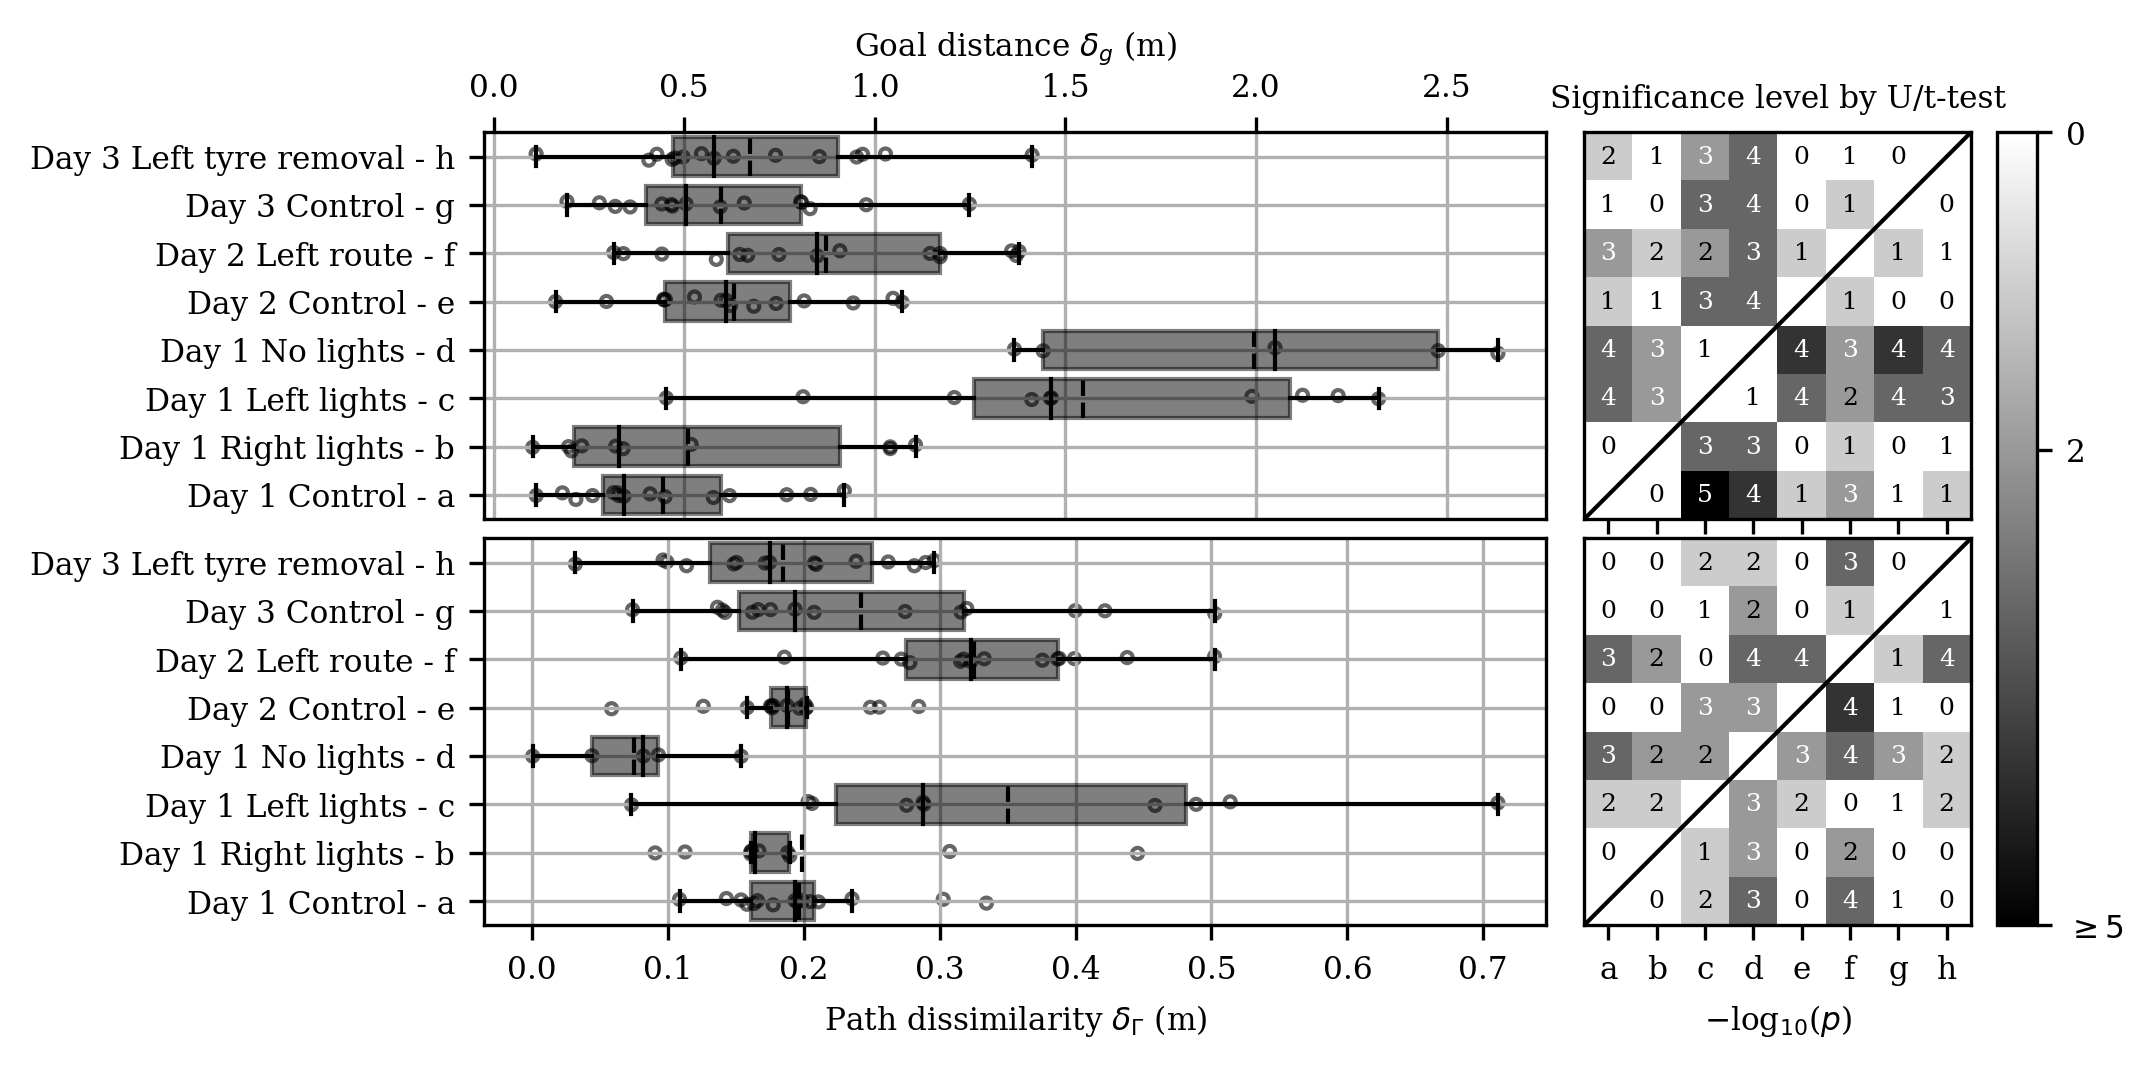

In [100]:
ls_cond = 'd1_control', 'd1_leftoff', 'd1_rightoff', 'd1_bothoff', 'd2_control', 'd2_left', 'd3_control', 'd3_nowheel'
ls_cond_name = 'Day 1 Control - a', 'Day 1 Right lights - b', 'Day 1 Left lights - c', 'Day 1 No lights - d', 'Day 2 Control - e', 'Day 2 Left route - f', 'Day 3 Control - g', 'Day 3 Left tyre removal - h'

data_goaldist = [data_summary['d2go'][model_name] for model_name in ls_cond]
data_pathdsim = [data_summary['dsim'][model_name] for model_name in ls_cond]

plot2metric(data_goaldist, data_pathdsim, ls_cond_name, ('abcdefgh'), ('kkkkkkkk'), 
            dot_alpha=0.6, dot_size=7, figsize=(figw1, 3.5))

Ttest_indResult(statistic=16.63021363934042, pvalue=0.0)
Ttest_indResult(statistic=15.413385253708896, pvalue=0.0)


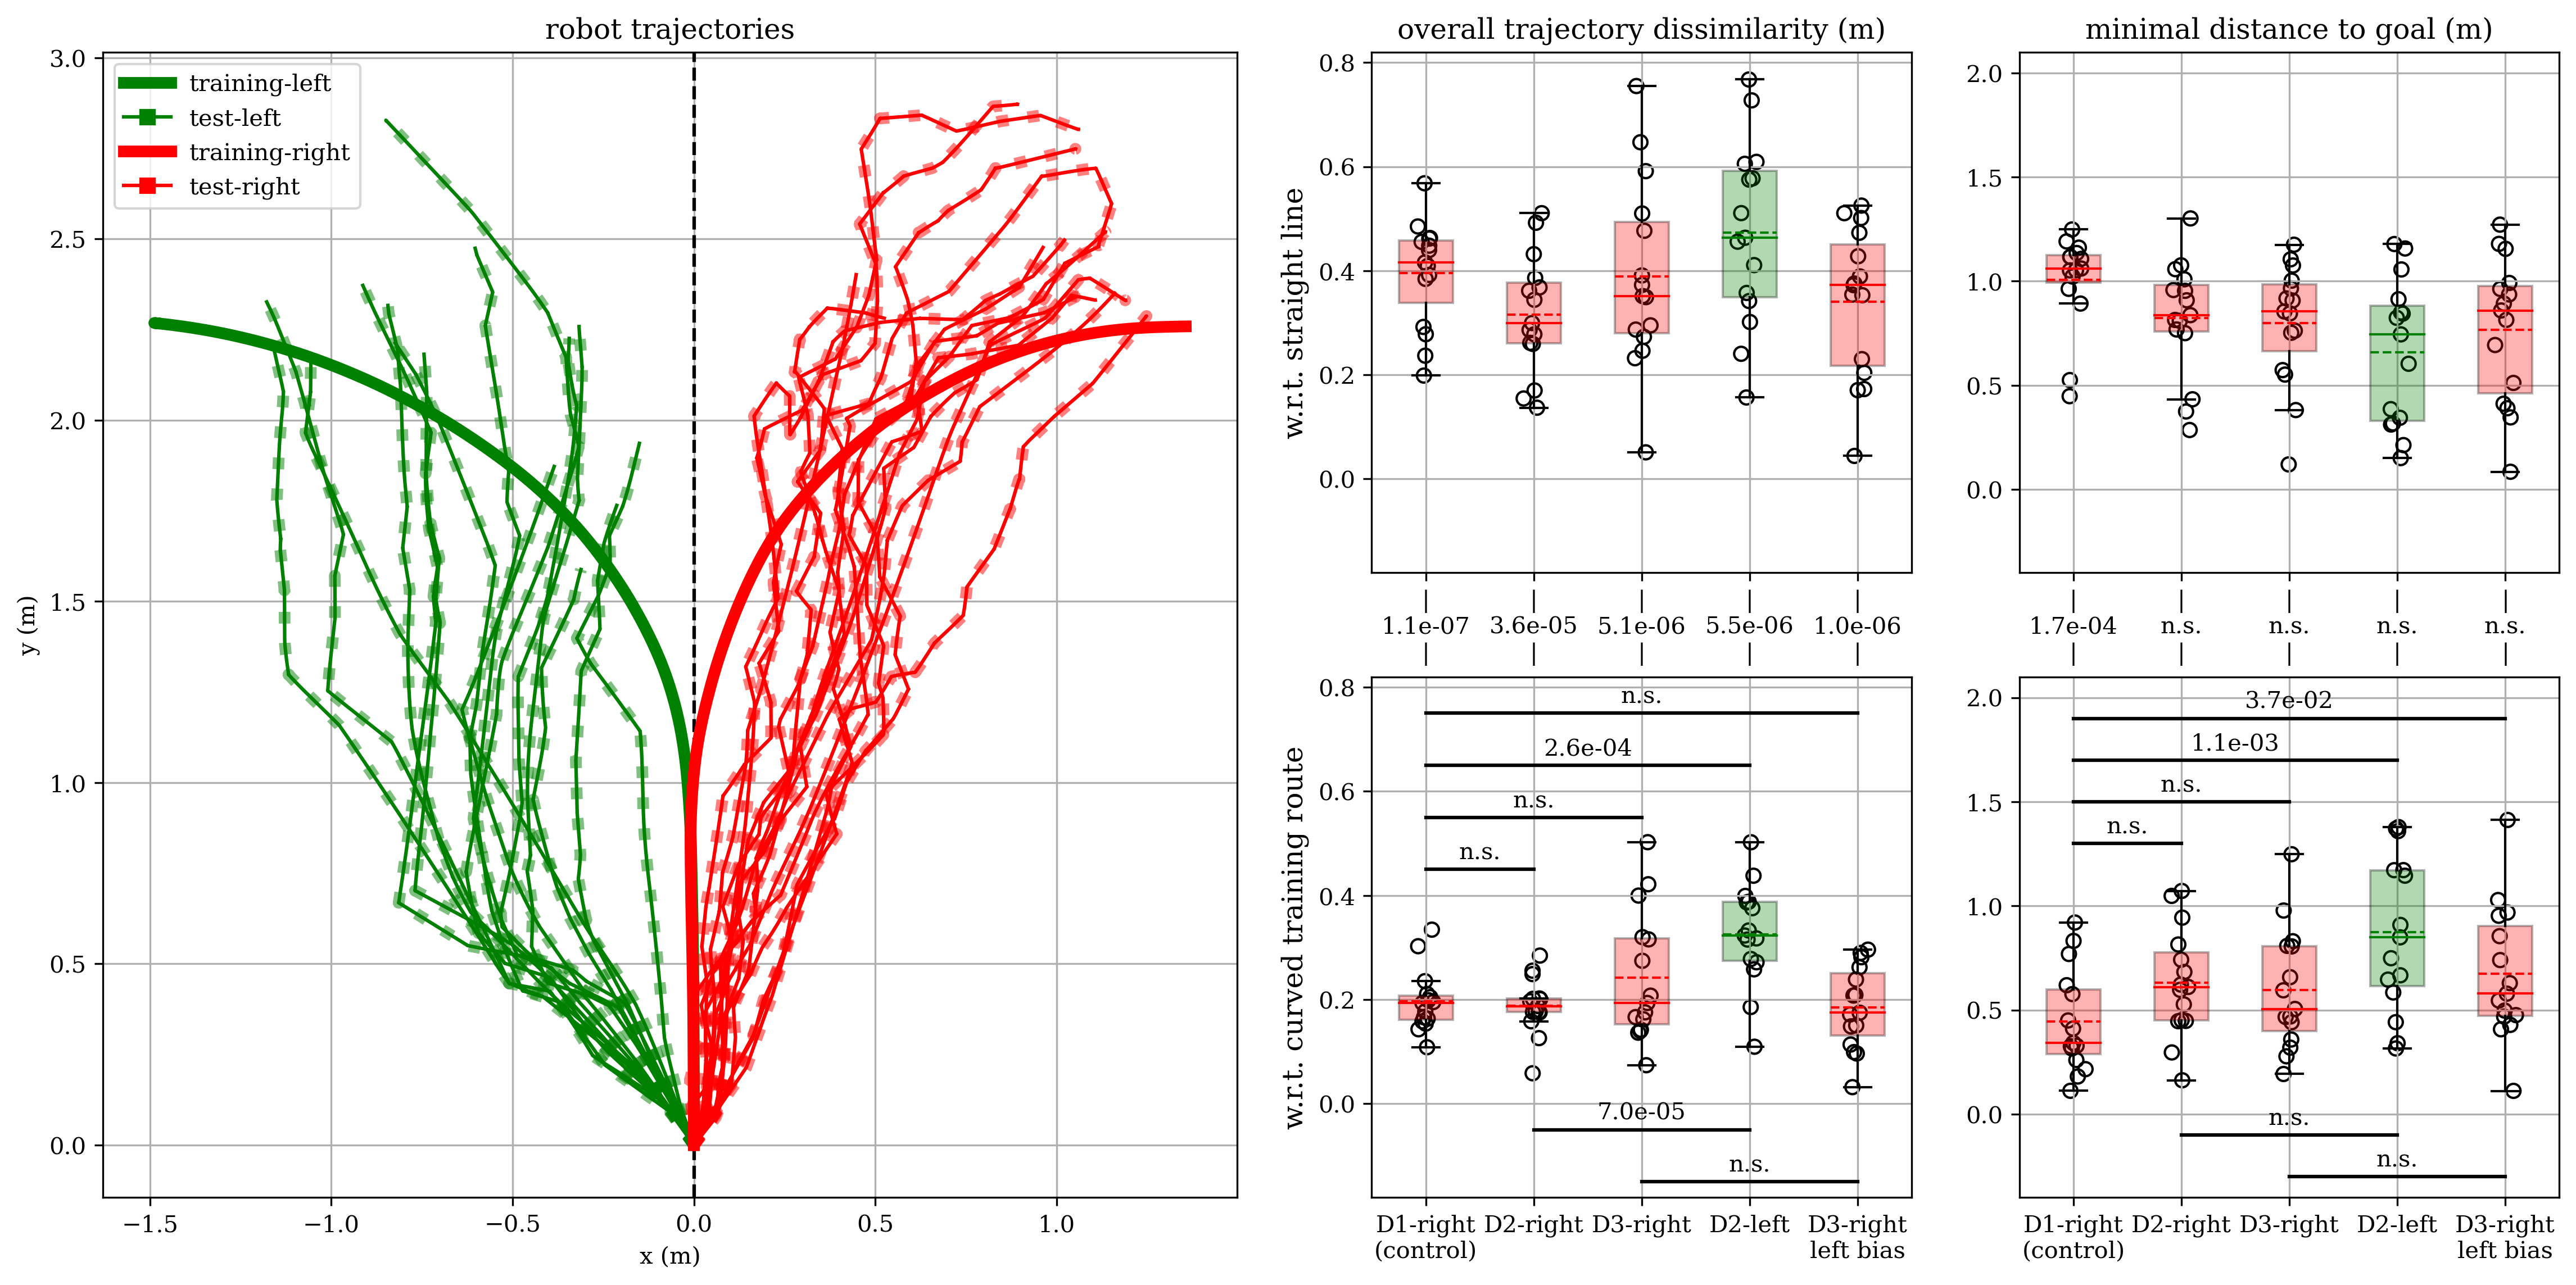

In [27]:
lw = 5

fig, axes = plt.subplot_mosaic('''
                                AABC
                                AADE
                                ''', figsize=(19, 9), dpi=300)

# axes['A'].plot([0, 0], [0, 2.9], c='b', lw=lw, label='straight line')
axes['A'].axvline(0, ls='dashed', color='k')
# axes['A'].plot(*data_pos['base'][0], color='k', lw=lw)
# left vs right trajectories
for lr, cond, color in zip(ls_lr, ('d2_left', 'd1_control'), 'gr'):
    axes['A'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c=color, lw=lw, label='training-{}'.format(lr))
    for x, y in data_test[cond]['pos']:
        axes['A'].plot(-y, x, color=color, ls='dotted', lw=lw, alpha=0.5)
        axes['A'].plot(-y, x, color=color)
        
    axes['A'].plot([], [], c=color, marker='s', label='test-{}'.format(lr))

axes['A'].set_xlabel('x (m)')
axes['A'].set_ylabel('y (m)')
axes['A'].set_aspect('equal')
axes['A'].legend()
axes['A'].set_title('robot trajectories')

bc_xticklabel = []
de_pvalue = []
# boxplots
ls_cond = 'd1_control', 'd2_control', 'd3_control', 'd2_left', 'd3_nowheel'
for ak, key in zip('BCDE', 
                        ('dsim_line', 'd2go_line', 'dsim', 'd2go')):#, 
#                         ('overall trajectory dissimilarity (m)', 'minimal distance to goal (m)', '', '')):
    ax = axes[ak]
    ds = data_summary[key]
    pts = []
    for xx, cond in enumerate(ls_cond):
        yy = ds[cond]
        ax.scatter(np.random.normal(xx + 1, 0.04, len(yy)), yy, facecolor='none', edgecolor='k')
        pts.append(yy)
    bp = ax.boxplot(pts, showfliers=False, showmeans=True, meanline=True, patch_artist=True, widths=0.5,
                   labels=['D1-right\n(control)', 'D2-right', 'D3-right', 'D2-left', 'D3-right\nleft bias'])
    for patch, color in zip(bp['boxes'], 'rrrgr'):
        patch.set_facecolor(color)
        patch.set_alpha(0.3)
    for linekey in ('means', 'medians'):
        for line, color in zip(bp[linekey], 'rrrgr'):
            line.set_color(color)

    # statistics
    if key in ('dsim_line', 'd2go_line'):
        # left versus right
        print(stats.ttest_ind(pts[3], -np.array(pts[0]), permutations=100000))
        
    else:
        # compare straight line to training route
        route_line_p = []
        for xx, cond in enumerate(ls_cond):
            y1, y0 = data_summary[key][cond], data_summary['{}_line'.format(key)][cond]
            tp = stats.ttest_rel(y1, y0, alternative='less').pvalue
            if tp <= 0.05:
                plabel = '{:.1e}'.format(tp)
            else:
                plabel = 'n.s.'
            route_line_p.append('|\n{}\n|'.format(plabel))
                
        bc_xticklabel.append(route_line_p)
        
        # compare performance across conditions
        cond_p = [stats.ttest_ind(p, pts[0], permutations=100000).pvalue for p in pts[1:]]
        cond_p.extend([stats.ttest_ind(pts[3], pts[1], permutations=100000).pvalue, stats.ttest_ind(pts[4], pts[2], permutations=100000).pvalue])
        de_pvalue.append(cond_p)

for ak, pvals, h, yy in zip('DE', de_pvalue, (.02, 0.05), ((.45, .55, .65, .75, -.05, -.15), (1.3, 1.5, 1.7, 1.9, -.1, -0.3))):
    for pval, x0, x1, y in zip(pvals, (1, 1, 1, 1, 2, 3), (2, 3, 4, 5, 4, 5), yy):
        axes[ak].plot([x0, x1], [y, y], color='k')
        if pval <= 0.05:
            plabel = '{:.1e}'.format(pval)
        else:
            plabel = 'n.s.'
        axes[ak].text((x0 + x1) / 2, y + h, plabel, horizontalalignment='center')
        
        
        
for ak in 'ABCDE':
    axes[ak].grid()
    
for ak, yl in zip('BD', ('w.r.t. straight line', 'w.r.t. curved training route')):
    axes[ak].set_ylim(-0.18, 0.82)
    axes[ak].set_ylabel(yl, fontsize=12)
    
for ak in 'CE':
    axes[ak].set_ylim(-0.4, 2.1)
    
for ak, lb, tit in zip('BC', bc_xticklabel, ('overall trajectory dissimilarity (m)', 'minimal distance to goal (m)')):
    axes[ak].set_xticklabels(lb)
    axes[ak].set_title(tit)

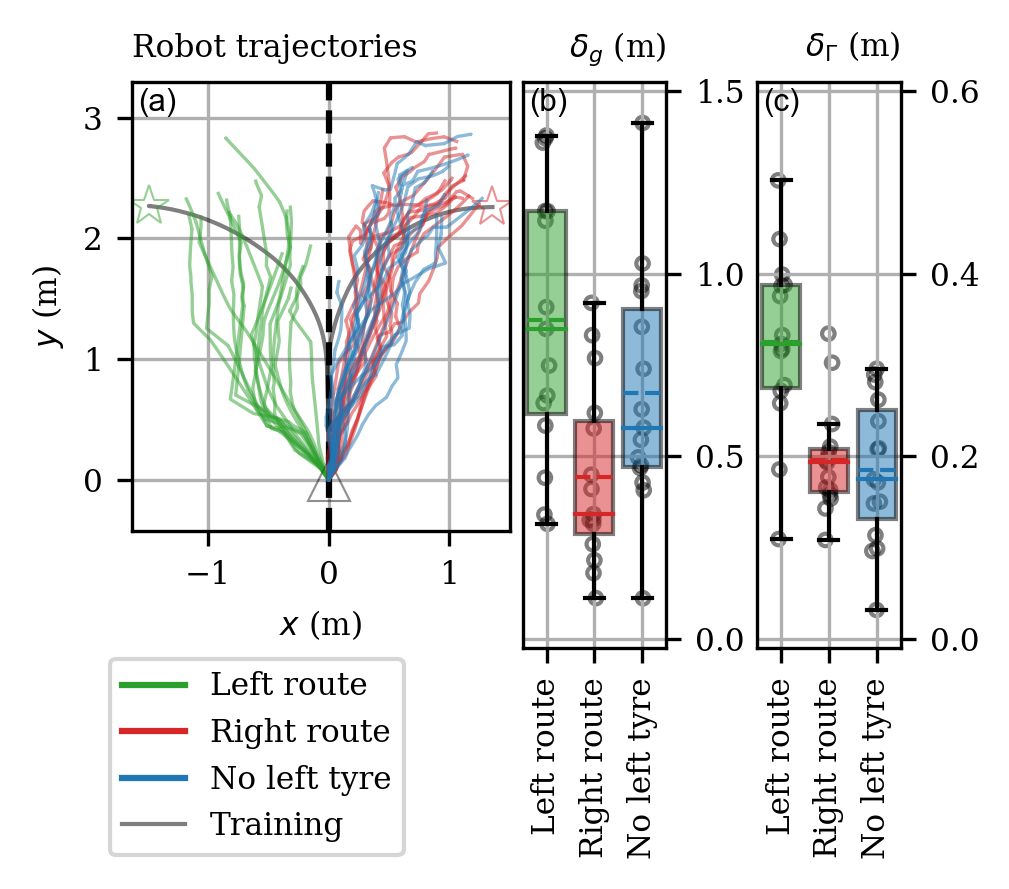

In [152]:
lw = 1

fig, axes = plt.subplot_mosaic('''
                                AAAAABB.CC
                                AAAAABB.CC
                                AAAAABB.CC
                                AAAAABB.CC
                                .....BB.CC
                                ''', figsize=(figw2, 2.5), dpi=300)

axes['A'].axvline(0, ls='dashed', color='k')
    
ls_conditions = 'd2_left', 'd1_control', 'd3_nowheel'
ls_colors = 'tab:green', 'tab:red', 'tab:blue'
ls_condnames = 'Left route', 'Right route', 'No left tyre'

for lrc, cond, color in zip(ls_condnames, ls_conditions, ls_colors):
    axes['A'].plot([], [], c=color, label='{}'.format(lrc))
    if lrc in ('Left route', 'Right route'):
        lr = lrc.split(' ')[0].lower()
        axes['A'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c='k', lw=lw, alpha=0.5)

        axes['A'].plot(-data_train[lr]['pos'][0][1][0], data_train[lr]['pos'][0][0][0], c='k', alpha=0.25, 
                    marker='^', markersize=10, mfc='none', markeredgewidth=lw/2)
        axes['A'].plot(-data_train[lr]['pos'][0][1][-1], data_train[lr]['pos'][0][0][-1], c=color, alpha=0.5, 
                    marker='*', markersize=10, mfc='none', markeredgewidth=lw/2)

    for x, y in data_test[cond]['pos']:
        axes['A'].plot(-y, x, color=color, alpha=0.5, lw=0.8)

            
    
    

    
axes['A'].plot([], [], c='k', label='Training', lw=lw, alpha=0.5)

axes['A'].set_xlabel('$x$ (m)')
axes['A'].set_ylabel('$y$ (m)')
axes['A'].set_aspect('equal', adjustable='datalim')
axes['A'].legend(ncol=1, loc='upper left', bbox_to_anchor=(-0.1, -0.25))
axes['A'].set_title('Robot trajectories', fontsize=7.5, loc='left')

axes['A'].set_yticks(np.arange(4))



for ak, key, tit in zip('BC', 
                    ('d2go', 'dsim'),
                    ('$\delta_g$ (m)', '$\delta_\Gamma$ (m)')):
    ax = axes[ak]
    myboxplot(ax, [data_summary[key][_] for _ in ls_conditions], ls_condnames, ls_colors, 0.5, 9)
    ax.set_xticklabels(ls_condnames, rotation=90)
    ax.set_title(tit, fontsize=7.5, loc='right')
    ax.yaxis.tick_right()

axes['B'].set_yticks(np.linspace(0, 1.5, 4))
axes['B'].set_ylim(-0.025, 1.525)
axes['C'].set_yticks(np.linspace(0, 0.6, 4))
axes['C'].set_ylim(-0.01, 0.61)
    
                   

for ax in axes.values():
#     ax.xaxis.set_tick_params(labelsize=6)
#     ax.yaxis.set_tick_params(labelsize=6)
    ax.grid()

    
    
complete_figure(axes, 'abc')

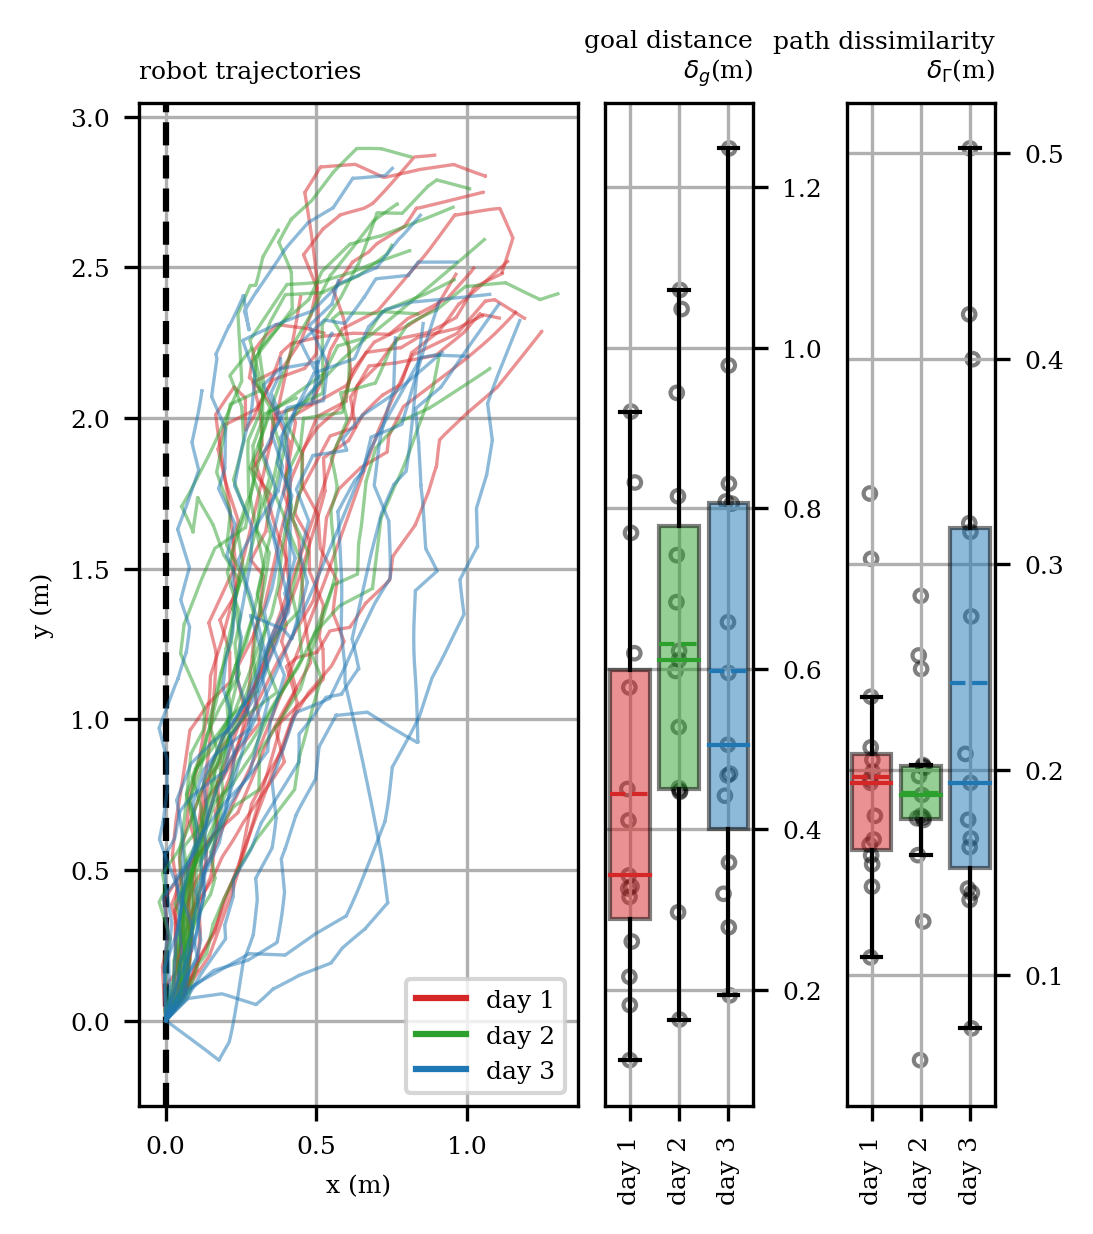

In [29]:
lw = 1

fig, axes = plt.subplot_mosaic('''
                                AAABC
                                ''', figsize=(3.5, 4), dpi=300, layout='constrained')

# axes['A'].plot([0, 0], [0, 2.9], c='b', lw=lw, label='straight line')
axes['A'].axvline(0, ls='dashed', color='k')
# axes['A'].plot(*data_pos['base'][0], color='k', lw=lw)
# left vs right trajectories
    
ls_conditions = 'd1_control', 'd2_control', 'd3_control'
ls_colors = 'tab:red', 'tab:green', 'tab:blue'
ls_condnames = 'day 1', 'day 2', 'day 3'

for lr, cond, color in zip(ls_condnames, ls_conditions, ls_colors):
    if lr in ls_lr:
        axes['A'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c='k', lw=lw, alpha=0.5)

        axes['A'].plot(-data_train[lr]['pos'][0][1][0], data_train[lr]['pos'][0][0][0], c='k', alpha=0.25, 
                    marker='^', markersize=10, mfc='none', markeredgewidth=lw/2)
        axes['A'].plot(-data_train[lr]['pos'][0][1][-1], data_train[lr]['pos'][0][0][-1], c=color, alpha=0.5, 
                    marker='*', markersize=10, mfc='none', markeredgewidth=lw/2)

    for x, y in data_test[cond]['pos']:
        axes['A'].plot(-y, x, color=color, alpha=0.5, lw=0.8)

            
    axes['A'].plot([], [], c=color, label='{}'.format(lr))
    
    

axes['A'].set_xlabel('x (m)', fontsize=6)
axes['A'].set_ylabel('y (m)', fontsize=6)
axes['A'].set_aspect('equal')
axes['A'].legend(fontsize=6)#, ncol=2, loc='upper left', bbox_to_anchor=(-0.1, -0.25))
axes['A'].set_title('robot trajectories', fontsize=6, loc='left')





for ak, key, tit in zip('BC', 
                    ('d2go', 'dsim'),
                    ('goal distance\n$\delta_g$(m)', 'path dissimilarity\n$\delta_\Gamma$(m)')):
    ax = axes[ak]
    myboxplot(ax, [data_summary[key][_] for _ in ls_conditions], ls_condnames, ls_colors, 0.5, 9)
    ax.set_xticklabels(ls_condnames, rotation=90)
    ax.set_title(tit, fontsize=6, loc='right')
    ax.yaxis.tick_right()

                   

for ax in axes.values():
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)
    ax.grid()


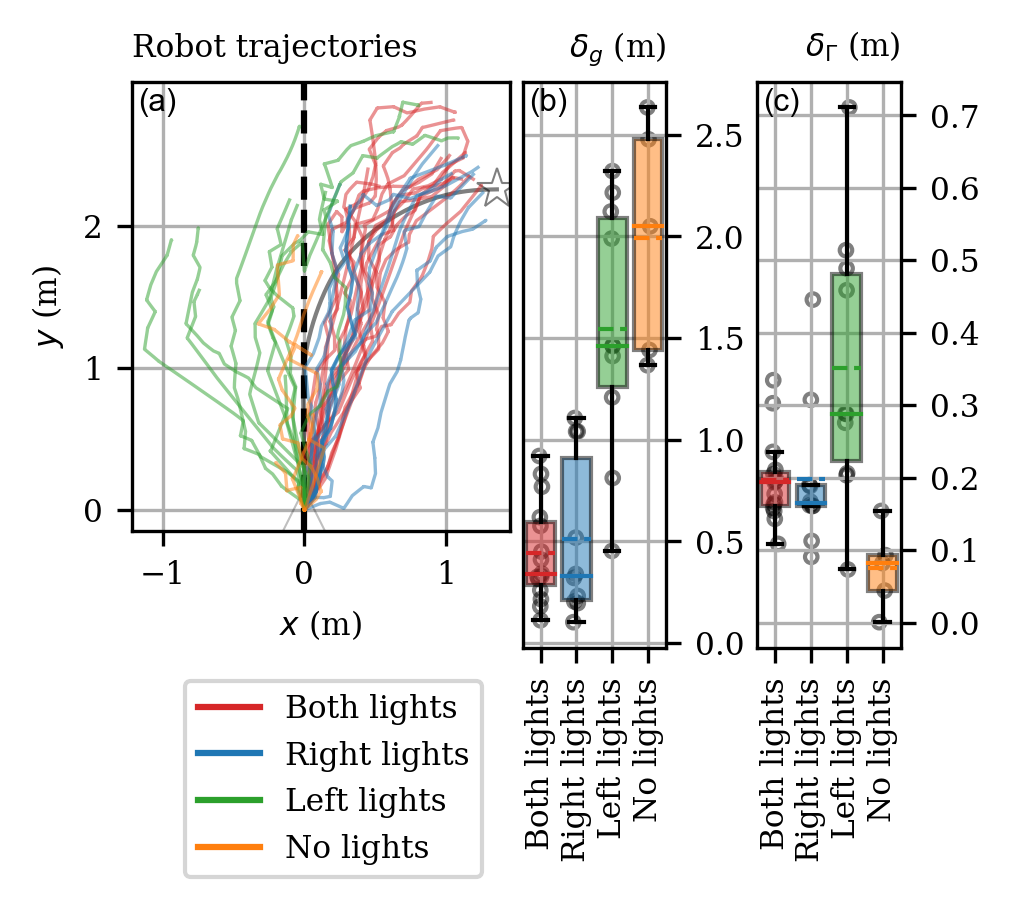

In [140]:
lw = 1

fig, axes = plt.subplot_mosaic('''
                                AAAAABB.CC
                                AAAAABB.CC
                                AAAAABB.CC
                                AAAAABB.CC
                                .....BB.CC
                                ''', figsize=(figw2, 2.5), dpi=300)

axes['A'].axvline(0, ls='dashed', color='k')
# left vs right trajectories

lr = 'right'
axes['A'].plot(-data_train[lr]['pos'][0][1], data_train[lr]['pos'][0][0], c='k', lw=lw, alpha=0.5)

axes['A'].plot(-data_train[lr]['pos'][0][1][0], data_train[lr]['pos'][0][0][0], c='k', alpha=0.25, 
            marker='^', markersize=10, mfc='none', markeredgewidth=lw/2)
axes['A'].plot(-data_train[lr]['pos'][0][1][-1], data_train[lr]['pos'][0][0][-1], c='k', alpha=0.5, 
            marker='*', markersize=10, mfc='none', markeredgewidth=lw/2)
    
ls_conditions = 'd1_control', 'd1_leftoff', 'd1_rightoff', 'd1_bothoff'
ls_colors = 'tab:red', 'tab:blue', 'tab:green', 'tab:orange'
ls_condnames = 'Both lights', 'Right lights', 'Left lights', 'No lights'

for lr, cond, color in zip(ls_condnames, ls_conditions, ls_colors):
    for x, y in data_test[cond]['pos']:
        axes['A'].plot(-y, x, color=color, alpha=0.5, lw=0.8)

            
    axes['A'].plot([], [], c=color, label='{}'.format(lr))
    
    
    

axes['A'].set_xlabel('$x$ (m)')
axes['A'].set_ylabel('$y$ (m)')
axes['A'].set_aspect('equal', adjustable='datalim')
axes['A'].set_yticks(np.arange(3))
axes['A'].legend(ncol=1, loc='upper left', bbox_to_anchor=(0.1, -0.3))
axes['A'].set_title('Robot trajectories', fontsize=7.5, loc='left')





for ak, key, tit in zip('BC', 
                    ('d2go', 'dsim'),
                    ('$\delta_g$ (m)', '$\delta_\Gamma$ (m)')):
    ax = axes[ak]
    myboxplot(ax, [data_summary[key][_] for _ in ls_conditions], ls_condnames, ls_colors, 0.5, 9)
    ax.set_xticklabels(ls_condnames, rotation=90)
    ax.set_title(tit, fontsize=7.5, loc='right')
    ax.yaxis.tick_right()

                   

for ax in axes.values():
#     ax.xaxis.set_tick_params(labelsize=6)
#     ax.yaxis.set_tick_params(labelsize=6)
    ax.grid()

    
complete_figure(axes, 'abc')
# import matplotlib.transforms as mtransforms
# trans = mtransforms.ScaledTranslation(0.02, -0.02, fig.dpi_scale_trans)
# for label, ax in zip('abc', axes.values()):
#     ax.text(0.0, 1.0, '({})'.format(label), transform=ax.transAxes + trans,
#             fontsize=6, verticalalignment='top', fontfamily='serif')